In [65]:
import plotly.express as px
import re
import seaborn as sns
import matplotlib. pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Index

- 문제정의
- 데이터 불러오기
- 데이터 전처리
- 데이터 활용

## 문제정의

- 최상위 랭커들의 게임 전적 분석으로 게임 실력 높이기

- 롤* 랭크게임에서는 자신의 게임 실력에 비례한 랭크가 부여된다:
    - 브론즈, 실버, 골드, 플레티넘, 다이아, 마스터, 그랜드마스터, 챌린저        
- 게임의 실력은 컨트롤(손가락 끝의 반응 속도)와 게임 흐름에 대한 이해도에 비례한다고 본다.
- 우리는 손가락이 굳었기 때문에 후자로 통해 롤에서 등급을 올리고 싶다.

- 롤* 이란:
    - 특정한 전장에서 하나의 캐릭터를 육성해 팀원들과 함께 적팀을 제압하는 게임 (최종적으로 본진 부시거나 상대팀이 4명 이상 항복하면 이길 수 있다)
    - 플레이어들은 게임에 앞서 자신이 조종할 챔피언(캐릭터)을 선택합니다.
    - 게임이 시작되면 자신이 선택한 챔피언으로 승리를 위해 적 플레이어들의 챔피언들과 맞서 싸워나갑니다.
    - 롤은 일반적으로 ‘소환사의 협곡’이라는 맵에서 5:5 경기가 진행됩니다.

# 데이터 불러오기

## 챌린저 티어 랭크게임 풀타임 전적 데이터

In [66]:
df_ = pd.read_csv("entire game dataset/Challenger_Ranked_Games.csv")

### 널 값 확인

In [67]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26904 entries, 0 to 26903
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   26904 non-null  int64  
 1   gameDuraton              26904 non-null  int64  
 2   blueWins                 26904 non-null  int64  
 3   blueFirstBlood           26904 non-null  int64  
 4   blueFirstTower           26904 non-null  int64  
 5   blueFirstBaron           26904 non-null  int64  
 6   blueFirstDragon          26904 non-null  int64  
 7   blueFirstInhibitor       26904 non-null  int64  
 8   blueDragonKills          26904 non-null  int64  
 9   blueBaronKills           26904 non-null  int64  
 10  blueTowerKills           26904 non-null  int64  
 11  blueInhibitorKills       26904 non-null  int64  
 12  blueWardPlaced           26904 non-null  int64  
 13  blueWardkills            26904 non-null  int64  
 14  blueKills             

널 값은 일단 없는걸로 확인

In [68]:
# 깊은복사
df_full = df_.copy()
df_full

gameId  gameDuraton  blueWins  blueFirstBlood  blueFirstTower  \
0      4247263043         1323         0               1               0   
1      4247155821         1317         1               0               0   
2      4243963257          932         0               0               0   
3      4241678498         2098         0               0               0   
4      4241538868         2344         1               1               1   
...           ...          ...       ...             ...             ...   
26899  4143231833         1468         0               1               0   
26900  4157911901          970         0               1               1   
26901  3764171638         1480         0               1               1   
26902  4110201724         1837         1               1               0   
26903  4100240254          948         1               1               1   

       blueFirstBaron  blueFirstDragon  blueFirstInhibitor  blueDragonKills  \
0                   0                0                   0                0   
1                   0                1                   0                2   
2                   0                0                   0                0   
3                   1                1                   0                1   
4                   1                1                   1                2   
...               ...              ...                 ...              ...   
26899               0                0                   0                1   
26900               0                1                   0                3   
26901               0                1                   0                1   
26902               0                1                   0                3   
26903               0                0                   0                1   

       blueBaronKills  ...  redAssist  redChampionDamageDealt  redTotalGold  \
0                   0  ...         68                   73016         49832   
1                   0  ...          8                   44218         37136   
2                   0  ...         20                   30797         35364   
3                   1  ...         72                  125866         70528   
4                   2  ...         83                  131536         74596   
...               ...  ...        ...                     ...           ...   
26899               0  ...         40                   75531         46558   
26900               0  ...         31                   99837         70177   
26901               0  ...         34                   55214         48849   
26902               0  ...         29                   88366         52625   
26903               0  ...          3                   16574         20972   

       redTotalMinionKills  redTotalLevel  redAvgLevel  redJungleMinionKills  \
0                      533             64         12.8                   138   
1                      571             59         11.8                   134   
2                      400             50         10.0                    89   
3                      832             84         16.8                   205   
4                      794             85         17.0                   227   
...                    ...            ...          ...                   ...   
26899                  478             64         12.8                   141   
26900                  455             72         14.4                   136   
26901                  636             66         13.2                   175   
26902                  660             70         14.0                   168   
26903                  351             40          8.0                    56   

       redKillingSpree  redTotalHeal  redObjectDamageDealt  
0                    8         38711                 60463  
1                    3         24829                 14105  
2                    5         12589                 452

# 데이터 확인

In [69]:
df_full.columns

Index(['gameId', 'gameDuraton', 'blueWins', 'blueFirstBlood', 'blueFirstTower',
       'blueFirstBaron', 'blueFirstDragon', 'blueFirstInhibitor',
       'blueDragonKills', 'blueBaronKills', 'blueTowerKills',
       'blueInhibitorKills', 'blueWardPlaced', 'blueWardkills', 'blueKills',
       'blueDeath', 'blueAssist', 'blueChampionDamageDealt', 'blueTotalGold',
       'blueTotalMinionKills', 'blueTotalLevel', 'blueAvgLevel',
       'blueJungleMinionKills', 'blueKillingSpree', 'blueTotalHeal',
       'blueObjectDamageDealt', 'redWins', 'redFirstBlood', 'redFirstTower',
       'redFirstBaron', 'redFirstDragon', 'redFirstInhibitor',
       'redDragonKills', 'redBaronKills', 'redTowerKills', 'redInhibitorKills',
       'redWardPlaced', 'redWardkills', 'redKills', 'redDeath', 'redAssist',
       'redChampionDamageDealt', 'redTotalGold', 'redTotalMinionKills',
       'redTotalLevel', 'redAvgLevel', 'redJungleMinionKills',
       'redKillingSpree', 'redTotalHeal', 'redObjectDamageDealt'],
    

## 무의미 데이터 필터

### 레벨

In [70]:
fig = px.histogram(df_full, x="redAvgLevel")
fig.show()

fig = px.histogram(df_full, x="blueAvgLevel")
fig.show()

- Fulltime 게임 데이터 평균레벨 히스토그램이다
- AvgLevel이 0부터 3이하 사이에 또다른 작은 bell-curve 형태의 히스토그램이 보인다

### 와드 항목

In [71]:
fig = px.histogram(df_full, x="blueWardPlaced")
fig.show()

fig = px.histogram(df_full, x="redWardPlaced")
fig.show()

두 팀 모두 와드를 박은 갯수가 0인 데이터가 2000가까이 되는것도 이상하다

### 킬 항목

#### 챔피언

In [72]:
pd.crosstab(df_full["blueFirstBlood"], df_full["redFirstBlood"])

redFirstBlood       0      1
blueFirstBlood              
0                  54  13303
1               13547      0

- 두 팀 모두 첫 처치가 없는 게임 전적이 54개나 있다
- 첫 처치가 없는 게임은 정상적인 게임이라고 보기 어렵다

In [73]:
print((df_full['redKills'] == 0).sum())
print((df_full['blueKills'] == 0).sum())

148
137


팀간 킬이 0인 데이터도 정상적인 게임에서 벗어난다고 보기 쉽다

In [74]:
print((df_full["blueJungleMinionKills"] == 0).sum())
print((df_full["redJungleMinionKills"] == 0).sum())

1950
1963


- 일반적인 게임에서는 정글의 역할이 존재하고 정글은 정글 미니언을 처치하면서 성장을 한다
- 그런데 정글미니언킬이 0인 전적이 많다

In [75]:
# 일반적인 게임이 아니라 판단되어 모두 제거해준다
df_full = df_full[~((df_full['blueFirstBlood']) == 0 & (df_full['redFirstBlood'] == 0))]
df_full = df_full[df_full['redKills'] != 0]
df_full = df_full[df_full['blueKills'] != 0]
df_full = df_full[df_full["blueJungleMinionKills"] != 0]
df_full = df_full[df_full["redJungleMinionKills"] != 0]

In [76]:
fig = px.histogram(df_full, x="redAvgLevel")
fig.show()

fig = px.histogram(df_full, x="blueAvgLevel")
fig.show()

그 결과 히스토그램이 많이 양호해졌다

In [77]:
fig = px.histogram(df_full, x="blueWardPlaced")
fig.show()
print(df_full.blueWardPlaced.value_counts())

63     200
54     198
48     194
37     190
68     190
      ... 
170      1
162      1
217      1
161      1
0        1
Name: blueWardPlaced, Length: 178, dtype: int64


In [78]:
df_full

gameId  gameDuraton  blueWins  blueFirstBlood  blueFirstTower  \
0      4247263043         1323         0               1               0   
4      4241538868         2344         1               1               1   
5      4241394461         1567         1               1               1   
7      4233113995         1588         1               1               1   
8      4231100932         1618         1               1               1   
...           ...          ...       ...             ...             ...   
26899  4143231833         1468         0               1               0   
26900  4157911901          970         0               1               1   
26901  3764171638         1480         0               1               1   
26902  4110201724         1837         1               1               0   
26903  4100240254          948         1               1               1   

       blueFirstBaron  blueFirstDragon  blueFirstInhibitor  blueDragonKills  \
0                   0                0                   0                0   
4                   1                1                   1                2   
5                   0                0                   1                2   
7                   1                0                   1                2   
8                   1                0                   1                3   
...               ...              ...                 ...              ...   
26899               0                0                   0                1   
26900               0                1                   0                3   
26901               0                1                   0                1   
26902               0                1                   0                3   
26903               0                0                   0                1   

       blueBaronKills  ...  redAssist  redChampionDamageDealt  redTotalGold  \
0                   0  ...         68                   73016         49832   
4                   2  ...         83                  131536         74596   
5                   0  ...         34                   64242         44280   
7                   1  ...         30                   62134         47408   
8                   1  ...         34                   69840         49906   
...               ...  ...        ...                     ...           ...   
26899               0  ...         40                   75531         46558   
26900               0  ...         31                   99837         70177   
26901               0  ...         34                   55214         48849   
26902               0  ...         29                   88366         52625   
26903               0  ...          3                   16574         20972   

       redTotalMinionKills  redTotalLevel  redAvgLevel  redJungleMinionKills  \
0                      533             64         12.8                   138   
4                      794             85         17.0                   227   
5                      555             61         12.2                   140   
7                      608             63         12.6                   133   
8                      646             69         13.8                   159   
...                    ...            ...          ...                   ...   
26899                  478             64         12.8                   141   
26900                  455             72         14.4                   136   
26901                  636             66         13.2                   175   
26902                  660             70         14.0                   168   
26903                  351             40          8.0                    56   

       redKillingSpree  redTotalHeal  redObjectDamageDealt  
0                    8         38711                 60463  
4                    7         86431                 64141  
5                    3         23741                 201

26904개의 데이터에서 12467개로 줄었다

#### 바론

In [79]:
pd.crosstab(df_full.blueFirstBaron, df_full.blueBaronKills)

blueBaronKills     0     1    2   3  4
blueFirstBaron                        
0               8461   344   21   1  0
1                  0  3193  423  22  2

- 첫바론을 처치하지 못한 경우에도 팀이 바론을 처치한 갯수가 1이상인 경우가 있다
- FirstBaron은 첫 바론 처치라고 보기 어렵다

결론적으로, FirstBaron은 바론이전에 등장하는 전령이다

In [80]:
# 칼럼 명칭 __FirstBaron에서 변경 __RiftHerald로 변경
df_full["blueRiftHerald"], df_full["redRiftHerald"] = df_full.blueFirstBaron, df_full.redFirstBaron

In [81]:
df_full = df_full.drop(columns=["blueFirstBaron", 'redFirstBaron'])

## 항목간 상관관계 분석

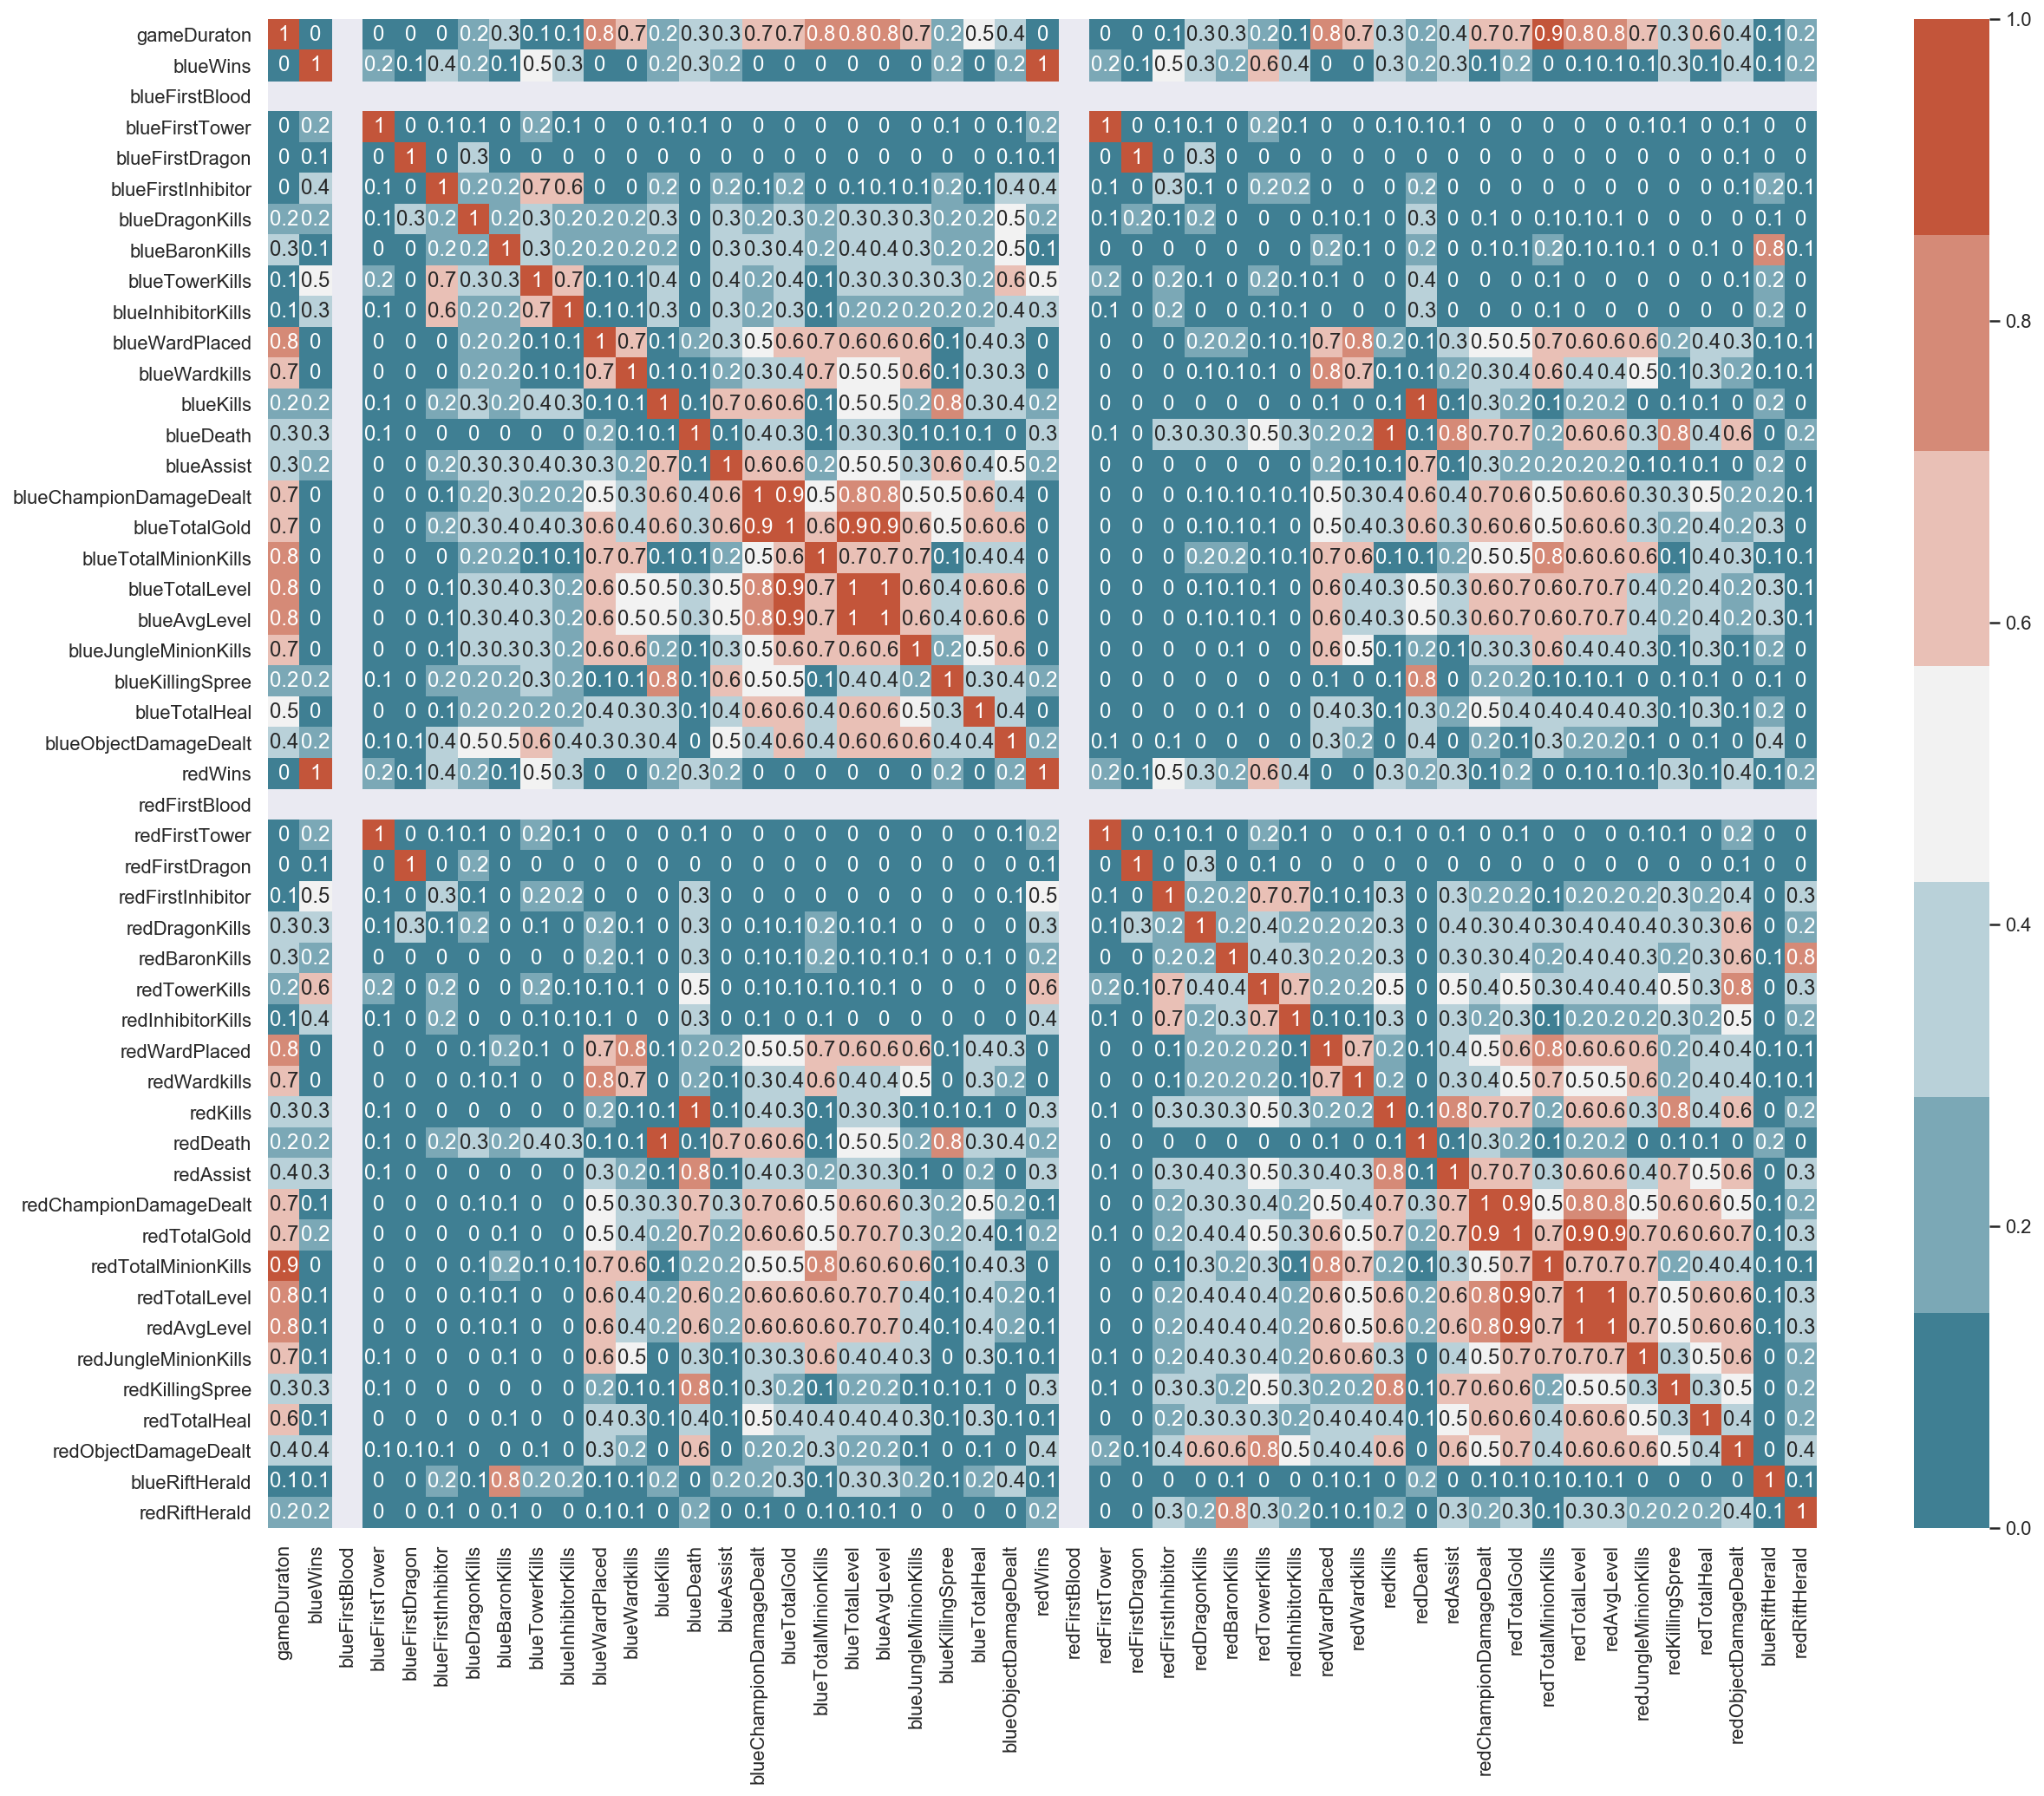

In [82]:
corr_mat = (df_full.drop(columns=['gameId']).corr()**2).round(1)
sns.set(rc={'figure.figsize': (20, 16)})
sns.heatmap(data=corr_mat, annot=True, cmap=sns.diverging_palette(220, 20, n=7))

 - 항목이 너무 많아서 다소 히트맵으로 시각화한게 무용지물이다

In [83]:
# 컬럼들 중 서로 관계지수가 0.8 이상인 항목 추출
dt = {}
a = []

for columns in corr_mat.columns:
    b = list(corr_mat[corr_mat[columns] >= 0.8].index)

    for items in b:
        if items in b:
            b.remove(items)

        dt[columns] = b
dt = {k: v for k, v in dt.items() if v != []}
dt

{'gameDuraton': ['blueWardPlaced',
  'blueTotalLevel',
  'redWardPlaced',
  'redTotalLevel'],
 'blueWins': ['redWins'],
 'blueFirstTower': ['redFirstTower'],
 'blueFirstDragon': ['redFirstDragon'],
 'blueBaronKills': ['blueRiftHerald'],
 'blueWardPlaced': ['blueWardPlaced'],
 'blueWardkills': ['redWardPlaced'],
 'blueKills': ['blueKillingSpree'],
 'blueDeath': ['redKills', 'redKillingSpree'],
 'blueChampionDamageDealt': ['blueTotalGold', 'blueAvgLevel'],
 'blueTotalGold': ['blueTotalGold', 'blueAvgLevel'],
 'blueTotalMinionKills': ['blueTotalMinionKills'],
 'blueTotalLevel': ['blueChampionDamageDealt', 'blueTotalLevel'],
 'blueAvgLevel': ['blueChampionDamageDealt', 'blueTotalLevel'],
 'blueKillingSpree': ['blueKillingSpree'],
 'redWins': ['redWins'],
 'redFirstTower': ['redFirstTower'],
 'redFirstDragon': ['redFirstDragon'],
 'redBaronKills': ['redRiftHerald'],
 'redTowerKills': ['redObjectDamageDealt'],
 'redWardPlaced': ['blueWardkills', 'redTotalMinionKills'],
 'redWardkills': ['red

### 높은 상관관계에 대한 정성적 분석

결정관계지수가 서로 1인 특성들 :
blueWin을 종속변수로 둘 때 가독성을 위해서 red 쪽 제거

- redWins < -> blueWins
- redFirstBlood < -> blueFirstBlood
- redFirstTower < -> blueFirstTower
- redKills < -> blueDeath
- redDeath < -> blueKills
- redWins < -> blueWins

df_c = df_c.drop(columns=["redWins", "redKills", "redDeath"])

"redFirstBlood","redFirstTower" 는 잠시 보류

0.8 이상 중 제거대상:

    - blueKills < -> blueAssist - 킬이 발생할때만 어시스트 발생
    - blueKills < -> blueKillingSpree
    - blueAvgLevel < -> blueChampionDamageDealt - 레벨이 올라갈수록 가할 수 있는 기본 데미지도 올라간다
    - blueAvgLevel < -> blueTotalGold - 레벨에 따라 전투력이 상승해 골드 획득 속도가 늘어난다
    - blueAvgLevel < -> bluetotallevel - 평균하고 총합(중 하난 빼야한다)

    - gameDuraton <-> blueTotalMinionKills - 게임이 진행되는 동안 미니언은 무한정으로 등장한다
    - gameDuraton <-> redTotalMinionKills - 게임이 진행될수록 챔피언 전투력이 상승해 미니언 처치가 쉬워진다
    - blueRiftHerald <-> blueBaronKills - 반면에 blueFirstDragon과 blueDragonKills는 0.3밖에 되지 않는다

    - redFirstBaron <-> redBaronKills

    - blueWardkills <-> redWardPlaced
    - redWardkills <-> blueWardplaced - 상대편이 와드를 설치해야 처치할 수 있는 일

    - blueWardPlaced <-> blueTotalMinionKills - 시간이 지날수록 많아지는 특성이 같다
    - blueWardPlaced <-> redWardPlaced - 개수의 차이가 승패를 좌지우지한다면 개수의 차이와 승패의 연관을 보는게 좋을거 같다 

관계에 대한 설명이 어렵다면 feature of importances에 가서 생각해보도록 하자

### 항목 제거

In [84]:
df_full["blueWardKillDiff"] = df_full.blueWardkills - df_full.redWardkills
df_full = df_full.drop(columns=['blueWardkills', 'redWardkills'])

In [85]:
# 특성들 중 'Total'이 들어간 항목들은 팀마다 있어서 중복된다
re.findall("\w+Total\w+", str(list(df_full)))

['blueTotalGold',
 'blueTotalMinionKills',
 'blueTotalLevel',
 'blueTotalHeal',
 'redTotalGold',
 'redTotalMinionKills',
 'redTotalLevel',
 'redTotalHeal']

경기마다 기록된 차이를 새로운 특성으로 만들고 원래 특성은 삭제하는게 좋다

In [86]:
# 경기마다 전적차이를 새로운 항목으로 만들고 항목 갯수를 줄이는게 더 좋다
# 정글미니언도 개수 차이로 특성을 변경해줬다
df_full["blueTotalGoldDiff"] = df_full.blueTotalGold - df_full.redTotalGold
df_full["blueLevelDiff"] = df_full.blueTotalLevel - df_full.redTotalLevel
df_full["blueTotalMinionKillDiff"] = df_full.blueTotalMinionKills - \
    df_full.redTotalMinionKills

In [87]:
df_full = df_full.drop(columns=[
    'blueTotalGold',
    'redTotalGold',
    'blueTotalLevel',
    'redTotalLevel',
    'blueTotalMinionKills',
    'redTotalMinionKills',
]
)

In [88]:
len(df_full.columns)

46

In [89]:
# 특성간에 히트맵을 쉽게 볼 수 있게 묶어서 전처리
df_full["FirstTowerDiff"] = df_full.blueFirstTower - df_full.redFirstTower
df_full["HeraldDiff"] = df_full.blueRiftHerald - df_full.redRiftHerald
df_full["FirstDragonDiff"] = df_full.blueFirstDragon - df_full.redFirstDragon
df_full["blueJungleMinionDiff"] = df_full.blueJungleMinionKills - \
    df_full.redJungleMinionKills
df_full["TotalAssistDiff"] = df_full.blueAssist - df_full.redAssist
df_full["AvgLevelDiff"] = df_full.blueAvgLevel - df_full.redAvgLevel
df_full["TowerKillDiff"] = df_full.blueTowerKills - df_full.redTowerKills

In [90]:
# 묶은 특성들 제거
df_full = df_full.drop(columns=[
    'blueJungleMinionKills',
    'redJungleMinionKills',
    'blueAssist',
    'redAssist',
    'blueTotalHeal',
    'redTotalHeal',
    'blueFirstBlood',
    'redFirstBlood',
    'blueFirstTower',
    'redFirstTower',
    'blueRiftHerald',
    'redRiftHerald',
    'blueFirstDragon',
    'redFirstDragon',
    'blueAssist',
    'redAssist',
    'blueAvgLevel',
    'redAvgLevel',
]
)

In [91]:
# 유의미 해보이는 항목들 이외에 제거
# 15분 데이터와 매칭할 수 있는 항목들 이외에 제거
df_full = df_full.drop(columns=[
    'blueTowerKills',
    'redTowerKills',
    'blueInhibitorKills',
    'redInhibitorKills',
    'blueFirstInhibitor',
    'redFirstInhibitor',
    'blueBaronKills',
    'redBaronKills',
    'blueChampionDamageDealt',
    'redChampionDamageDealt',
    'blueLevelDiff',
    'blueKillingSpree',
    'redKillingSpree',
    'blueObjectDamageDealt',
    'redObjectDamageDealt',
    'blueDragonKills',
    'redDragonKills',
]
)

### 히트맵 v2.0

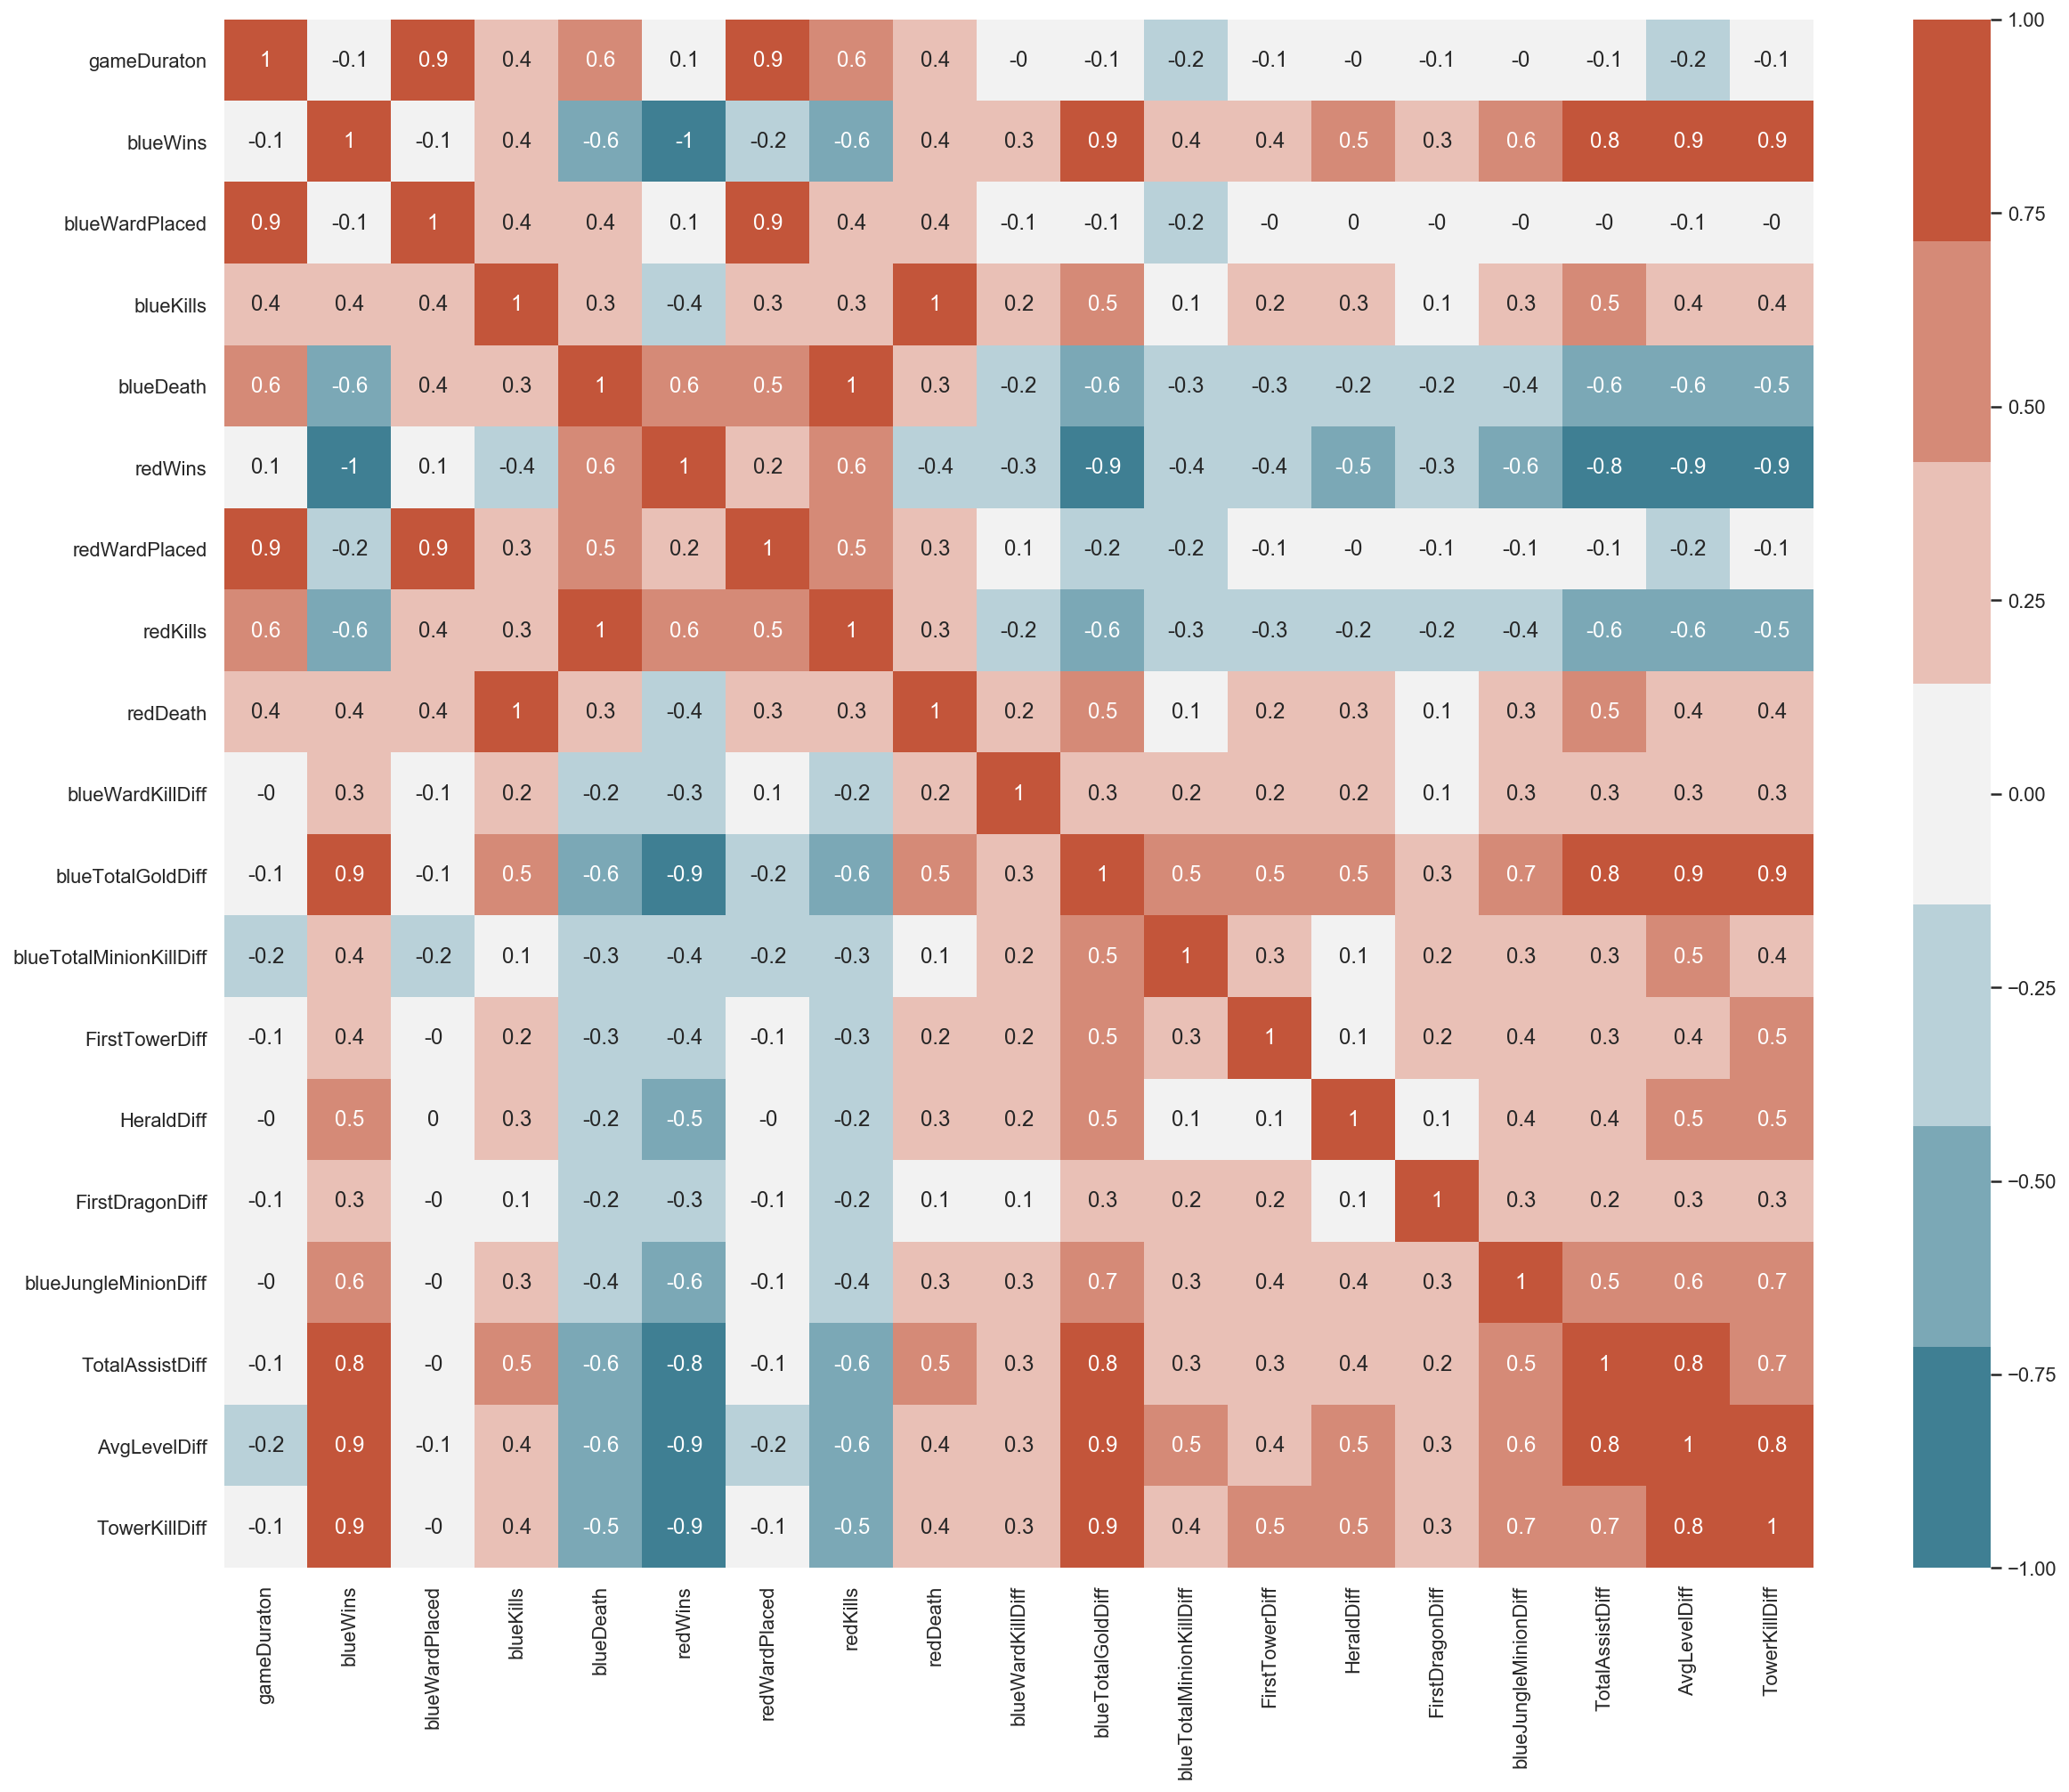

In [92]:
corr_mat_refined = (df_full.drop(columns=["gameId"]).corr()).round(1)
sns.set(rc={'figure.figsize': (20, 16)})
sns.heatmap(data=corr_mat_refined, annot=True, cmap=sns.diverging_palette(220, 20, n=7))

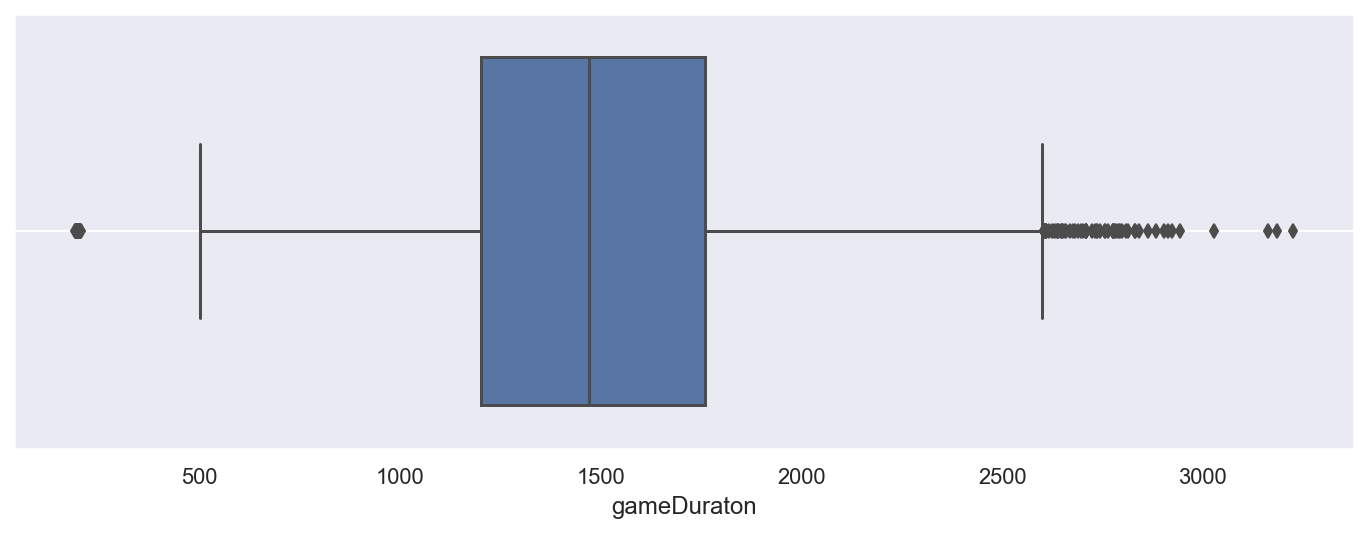

In [93]:
# 게임 진행시간
plt.figure(figsize=(12, 4))
sns.boxplot(df_full["gameDuraton"])
plt.grid()
plt.show()

In [94]:
q1 = np.percentile(df_full["gameDuraton"], 25)
q3 = np.percentile(df_full["gameDuraton"], 75)
iqr = q3 - q1
(q1-iqr*1.5)/60, q1/60, q3/60, (q3+iqr*1.5)/60

(6.041666666666667, 20.016666666666666, 29.333333333333332, 43.30833333333333)

잘하면 잘 할수록 안정적으로 플레이한다
다시 말해 리스크를 동반한 변수를 만들지 않고
상대팀이 아웃오브메타 상황에 진입했을때 그걸 우리팀이 유리하게 가져오는 위주로 플레이한다
더 많이 가져오는 팀이 이길 확률이 높아진다

게임시간이 길어질수록 오브젝트도 더 많이 처치하기 때문에 둘의 결정관계지수는 높을 것이라 예상
그러나 오브젝트들 마다 결정관계가 다르다.
우리는 이게 앞서 언급된 아웃오브메타에 대한 변수라고 주장
시간과 오브젝트 처치수의 결정관계가 높을수록 오브젝트를 가져오는건 메타
시간과 오브젝트 처치수의 결정관계가 낮을수록 오브젝트를 가져오는건 아웃오브메타

그래서 변수가 낮은 오브젝트를 노린다는건 가장 리스크가 동반됐다고 본다

- 1. 50%의 게임은 20분에서 30분 사이에 승패가 갈렸다.
- 2-1. 처치 가능한 오브젝트들 중 게임시간과 선형관계가 0.3 이하인 항목들:
    - 드래곤 0.2~0.3
    - 바론 0.3
    - 타워 0.2
    - 억제기 0.1
    - 챔피언 킬 데스 어시 각각 0.1씩 < -> 챔피언에게 가한 데미지는 0.5인 반면 잘 죽지 않는다
- 2-2. 처치 가능한 오브젝트들 중 게임시간과 선형관계가 높았던 항목들:
    - 정글 미니언 0.6
    - 미니언 0.8
    - 와드 0.7

In [95]:
df_full.reset_index(drop=True, inplace=True)

## 칼럼 중요도 파악

In [96]:
df_full.columns

Index(['gameId', 'gameDuraton', 'blueWins', 'blueWardPlaced', 'blueKills',
       'blueDeath', 'redWins', 'redWardPlaced', 'redKills', 'redDeath',
       'blueWardKillDiff', 'blueTotalGoldDiff', 'blueTotalMinionKillDiff',
       'FirstTowerDiff', 'HeraldDiff', 'FirstDragonDiff',
       'blueJungleMinionDiff', 'TotalAssistDiff', 'AvgLevelDiff',
       'TowerKillDiff'],
      dtype='object')

In [97]:
X = df_full.drop(['redWins', 'gameId', 'blueWins', 'gameDuraton'], axis=1)
y = df_full['blueWins']

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13)
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([3970, 6003]))

In [99]:
feature_name = list(X)
X_train.columns = feature_name
X_test.columns = feature_name
X_train.head()

blueWardPlaced  blueKills  blueDeath  redWardPlaced  redKills  \
8488               25         27         38             31        38   
7788               42          6         24             38        24   
2520               35          6         14             28        14   
12159              67         22         31             57        31   
11907              46         23         10             45        10   

       redDeath  blueWardKillDiff  blueTotalGoldDiff  blueTotalMinionKillDiff  \
8488         27                 2             -14848                      -55   
7788          6                -3             -13094                      -71   
2520          6                -5              -8362                      -53   
12159        22                 0              -3681                       -4   
11907        23                -4               7580                       29   

       FirstTowerDiff  HeraldDiff  FirstDragonDiff  blueJungleMinionDiff  \
8488               -1          -1               -1                  -110   
7788               -1           0               -1                   -43   
2520               -1           0                1                   -16   
12159               1          -1               -1                     8   
11907               1           0                1                    42   

       TotalAssistDiff  AvgLevelDiff  TowerKillDiff  
8488                -3          -1.2             -7  
7788               -36          -2.4             -8  
2520               -10          -0.8             -3  
12159              -28          -1.4              2  
11907                3           1.0              5

In [100]:
# 트레인 테스트 모델 데이터 갯수 일치한거 확인
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9973, 16), (2494, 16), (9973,), (2494,))

In [101]:
params = {
    'max_depth': [4, 6, 8, 10],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [8, 12],
    'min_samples_split': [8, 12]
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=13,
                                    

In [102]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [103]:
target_col = ['rank_test_score', 'mean_test_score',
              'param_n_estimators', 'param_max_depth']

In [104]:
cv_results_df[target_col].sort_values('rank_test_score').head()

rank_test_score  mean_test_score param_n_estimators param_max_depth
45                1         0.989772                 50              10
42                1         0.989772                 50              10
28                1         0.989772                100               8
25                1         0.989772                100               8
40                5         0.989772                100              10

In [105]:
grid_cv.best_params_

{'max_depth': 8,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 100}

In [106]:
grid_cv.best_score_

0.9897724858800552

In [107]:
rf_clf_best = grid_cv.best_estimator_
rf_clf_best.fit(X_train, y_train)

pred1 = rf_clf_best.predict(X_test)

accuracy_score(y_test, pred1)

0.9859663191659984

In [108]:
best_cols_values = rf_clf_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns)
top20_cols = best_cols.sort_values(ascending=False)[:20]
top20_cols

AvgLevelDiff               0.302980
blueTotalGoldDiff          0.282779
TowerKillDiff              0.208079
TotalAssistDiff            0.096391
blueJungleMinionDiff       0.037618
blueDeath                  0.018011
HeraldDiff                 0.016312
redKills                   0.016109
blueKills                  0.008807
redDeath                   0.006940
FirstTowerDiff             0.001945
blueTotalMinionKillDiff    0.001590
redWardPlaced              0.000811
blueWardPlaced             0.000799
blueWardKillDiff           0.000694
FirstDragonDiff            0.000136
dtype: float64

In [109]:
pd.DataFrame(top20_cols)

0
AvgLevelDiff             0.302980
blueTotalGoldDiff        0.282779
TowerKillDiff            0.208079
TotalAssistDiff          0.096391
blueJungleMinionDiff     0.037618
blueDeath                0.018011
HeraldDiff               0.016312
redKills                 0.016109
blueKills                0.008807
redDeath                 0.006940
FirstTowerDiff           0.001945
blueTotalMinionKillDiff  0.001590
redWardPlaced            0.000811
blueWardPlaced           0.000799
blueWardKillDiff         0.000694
FirstDragonDiff          0.000136

/Users/dy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



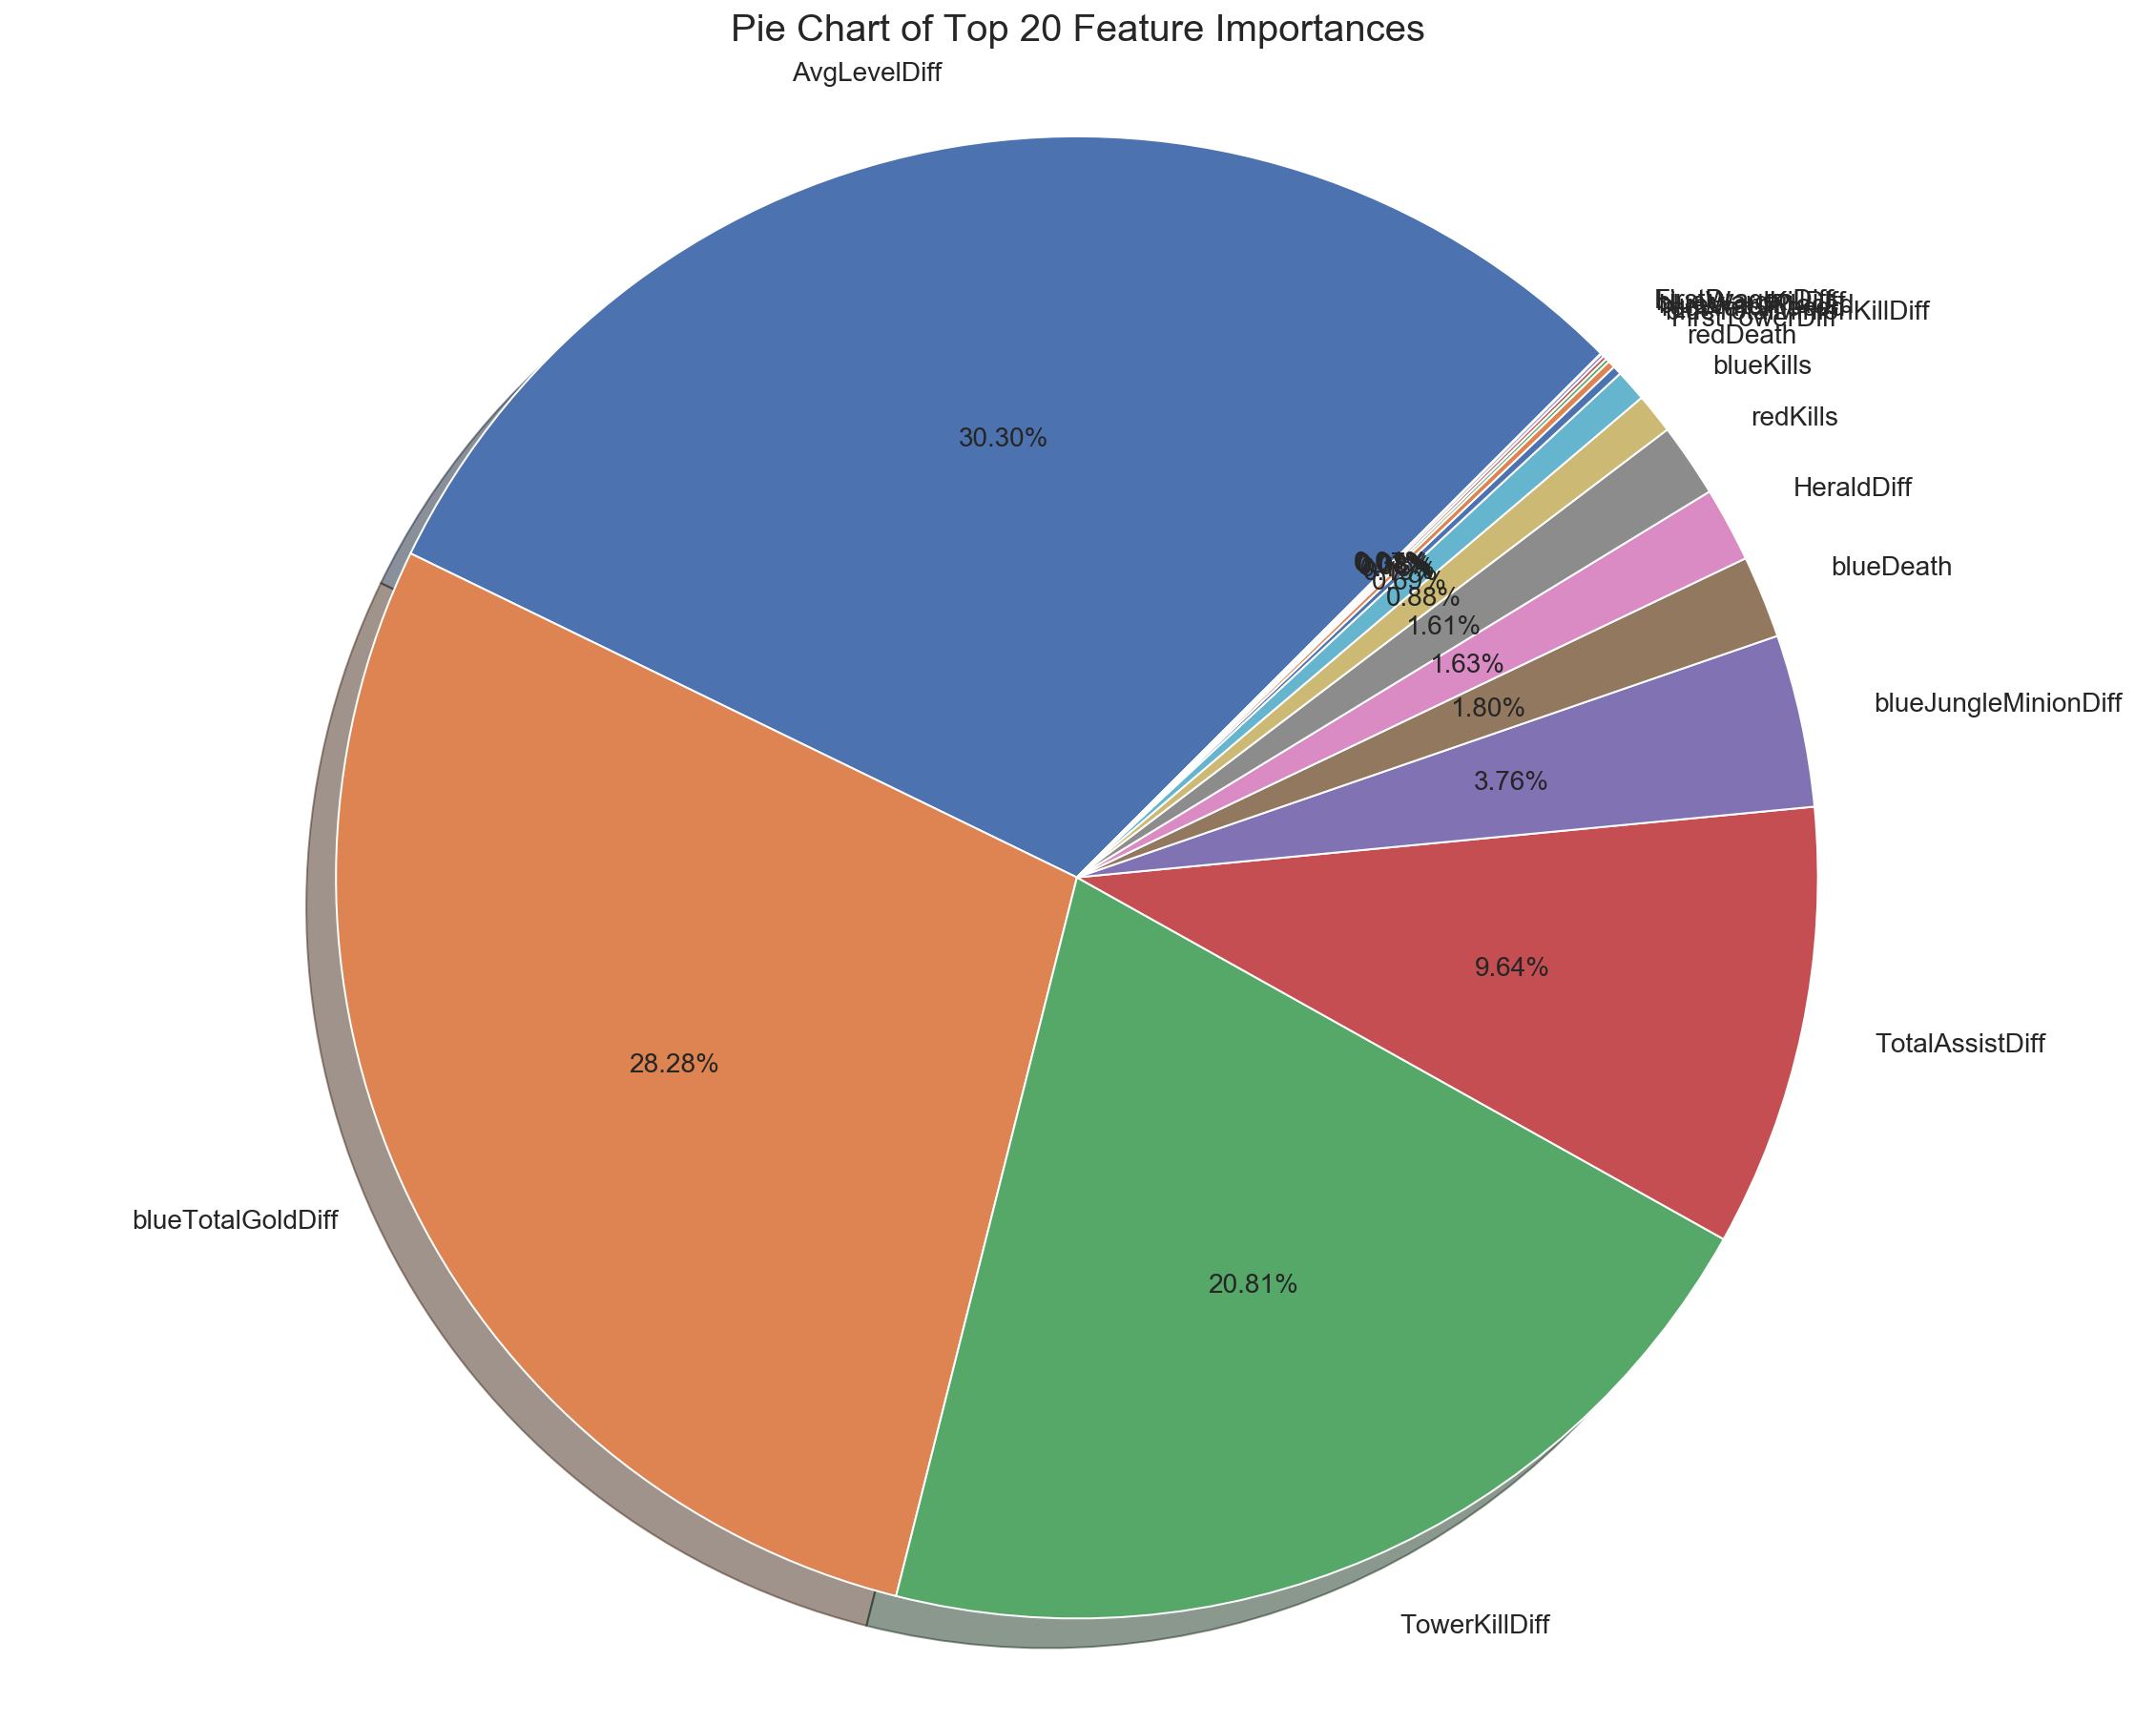

In [114]:
x = pd.DataFrame(top20_cols)
plt.pie(x,
        labels=x.index, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=45,
        textprops={'fontsize': 14}) # text font size

plt.axis('equal')
plt.title('Pie Chart of Top 20 Feature Importances', fontsize=20)

plt.show()


# etc.

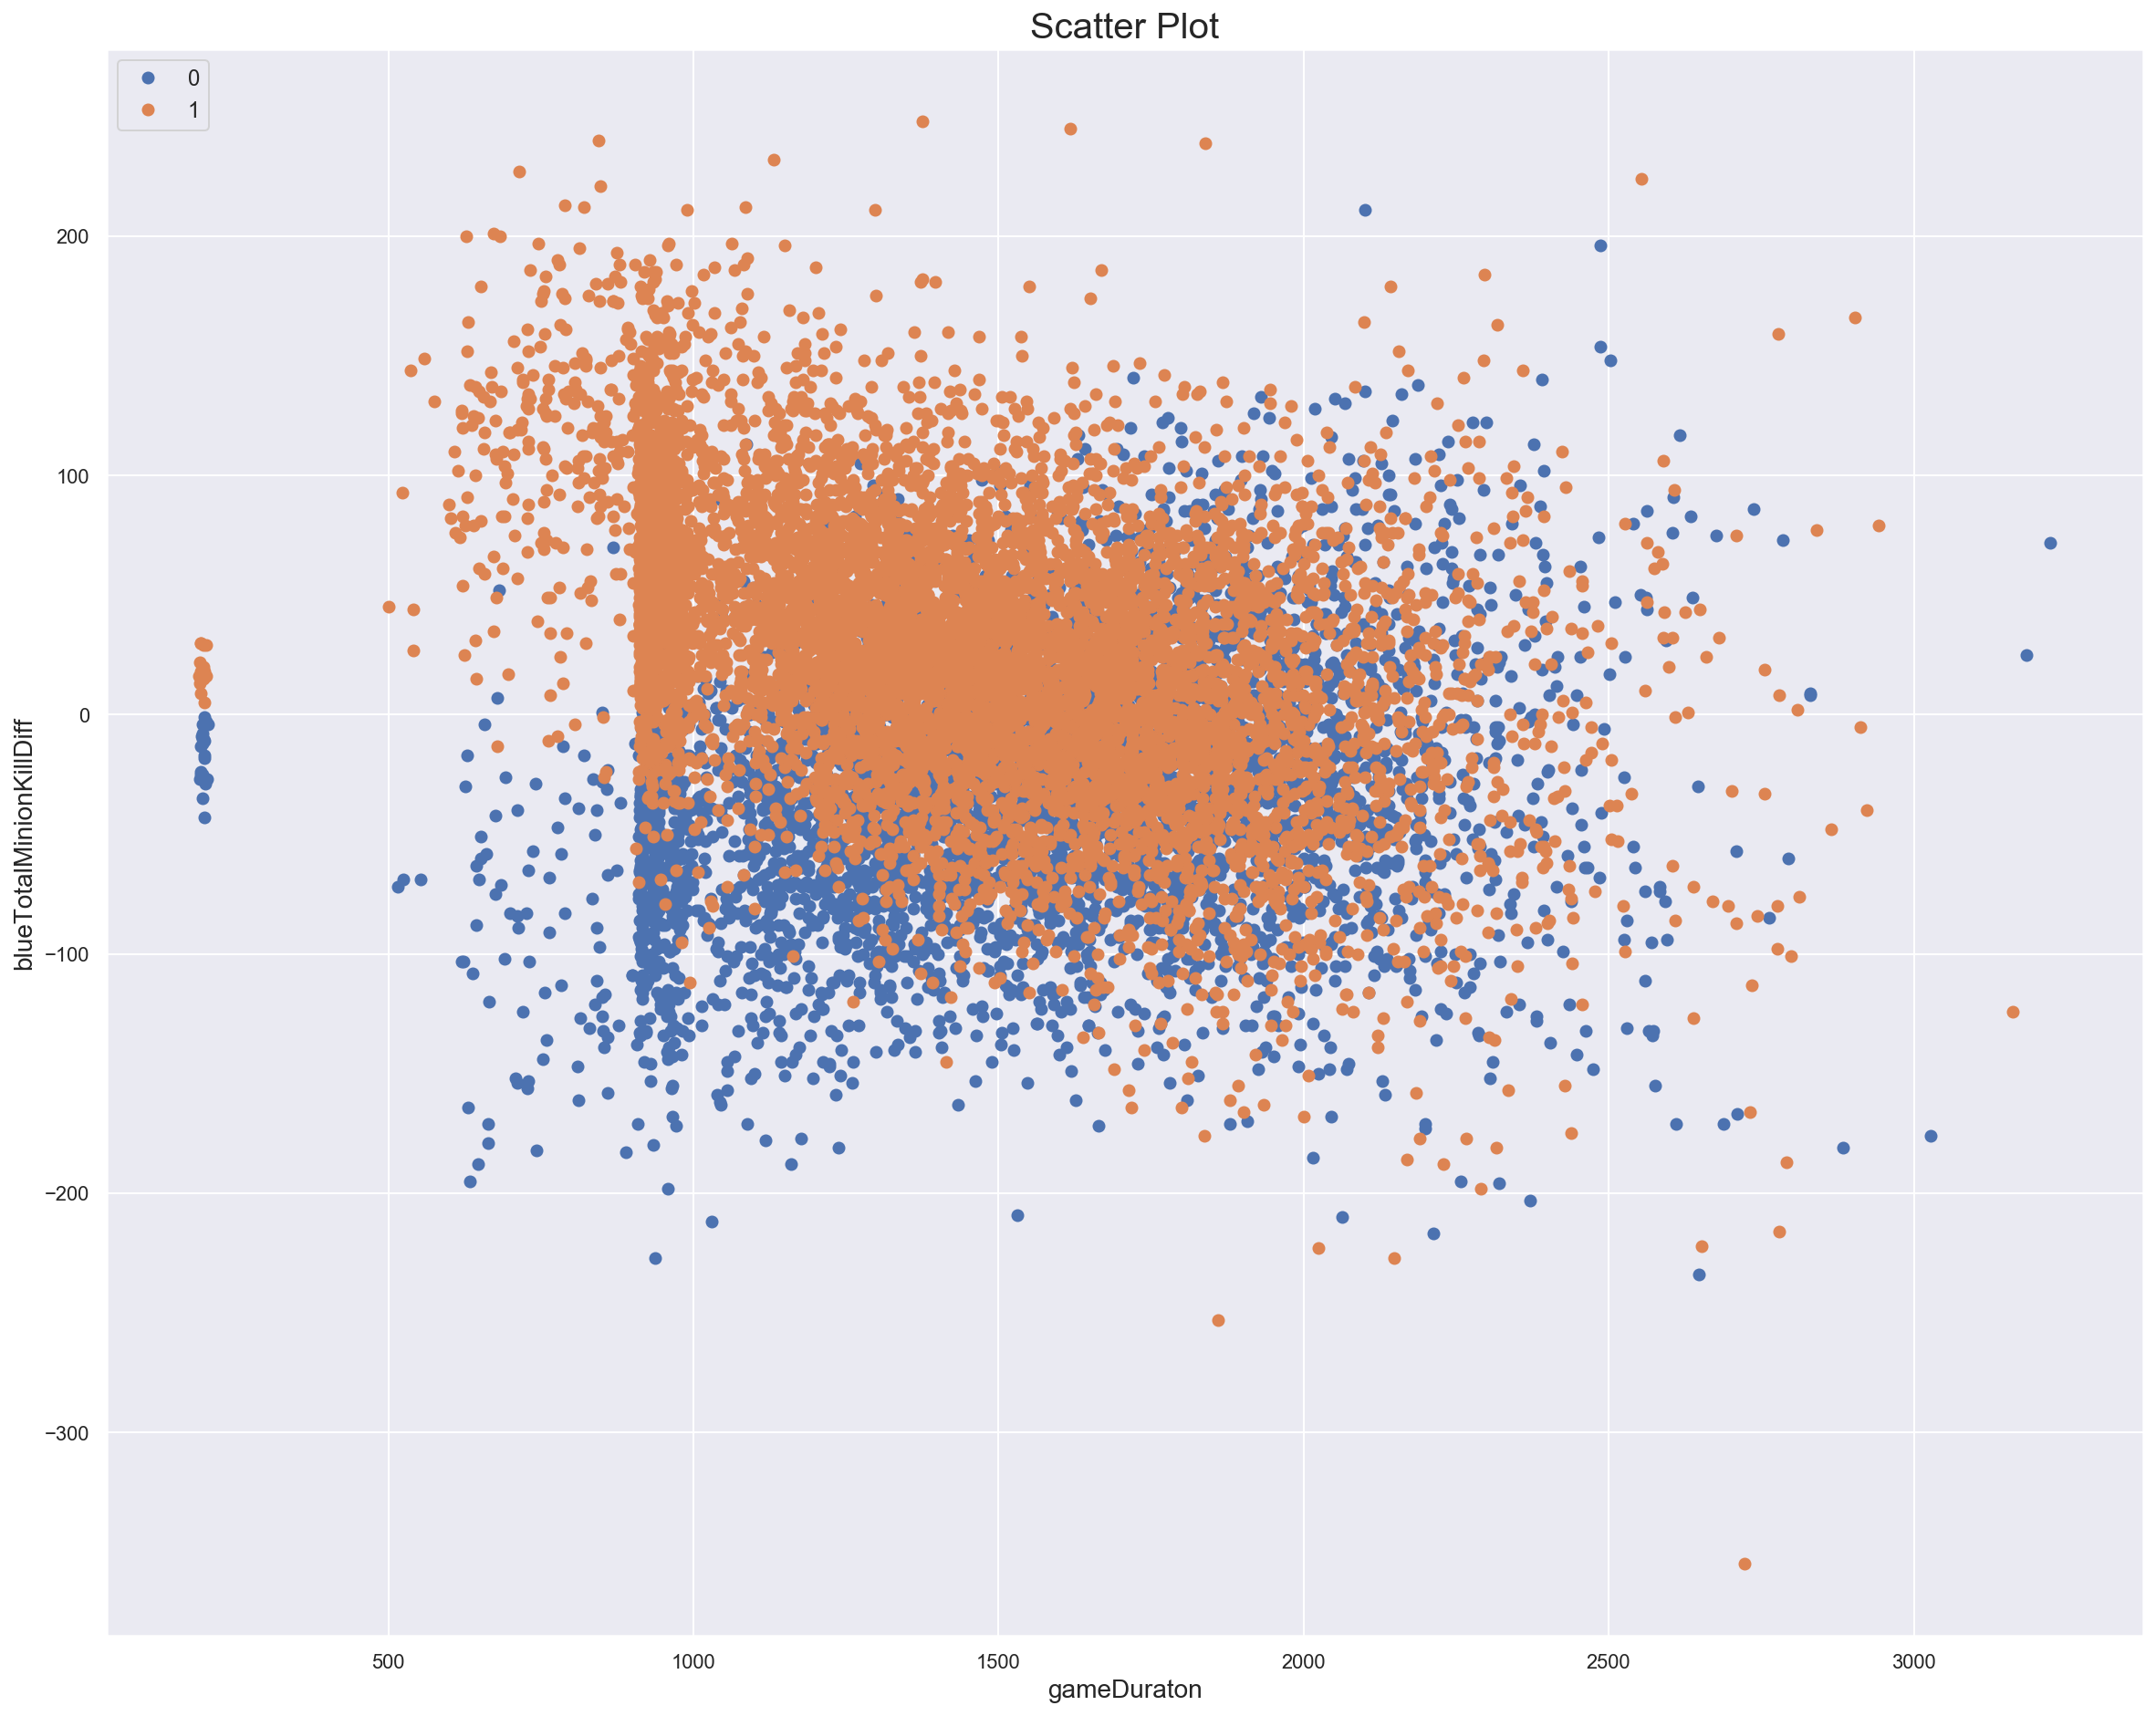

In [45]:
groups = df_full.groupby('blueWins')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.gameDuraton,
            group.blueTotalMinionKillDiff,
            marker='o',
            linestyle='',
            label=name)

ax.legend(fontsize=12, loc='upper left')

plt.title('Scatter Plot', fontsize=20)
plt.xlabel('gameDuraton', fontsize=14)
plt.ylabel('blueTotalMinionKillDiff', fontsize=14)

plt.show()

In [46]:
dt = DecisionTreeClassifier(max_depth=4, random_state=13)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)
print(accuracy_score(y_test, pred))

0.9859663191659984


In [47]:
lr = LogisticRegression(random_state=13, solver='liblinear')
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
print(accuracy_score(y_test, pred))

0.9807538091419407


In [48]:
rf = RandomForestClassifier(random_state=13, n_estimators=100, max_depth=4)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(accuracy_score(y_test, pred))

0.9855653568564555


In [49]:
estimators = [('Scaler', StandardScaler()),
              ('clf', RandomForestClassifier(random_state=13))]

pipe = Pipeline(estimators)

In [50]:
params = [{
    'clf__max_depth': [6, 8, 10, 100],
    'clf__n_estimators': [50, 100, 200, 1000]
}]

gridsearch = GridSearchCV(estimator=pipe, param_grid=params,
                          return_train_score=True, cv=5, verbose=2)
gridsearch.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] clf__max_depth=6, clf__n_estimators=50 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... clf__max_depth=6, clf__n_estimators=50, total=   0.7s
[CV] clf__max_depth=6, clf__n_estimators=50 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ........... clf__max_depth=6, clf__n_estimators=50, total=   0.6s
[CV] clf__max_depth=6, clf__n_estimators=50 ..........................
[CV] ........... clf__max_depth=6, clf__n_estimators=50, total=   0.5s
[CV] clf__max_depth=6, clf__n_estimators=50 ..........................
[CV] ........... clf__max_depth=6, clf__n_estimators=50, total=   0.5s
[CV] clf__max_depth=6, clf__n_estimators=50 ..........................
[CV] ........... clf__max_depth=6, clf__n_estimators=50, total=   0.6s
[CV] clf__max_depth=6, clf__n_estimators=100 .........................
[CV] .......... clf__max_depth=6, clf__n_estimators=100, total=   1.2s
[CV] clf__max_depth=6, clf__n_estimators=100 .........................
[CV] .......... clf__max_depth=6, clf__n_estimators=100, total=   1.1s
[CV] clf__max_depth=6, clf__n_estimators=100 .........................
[CV] .......... clf__max_depth=6, clf__n_estimators=100, total=   1.2s
[CV] clf__max_depth=6, clf__n_estimators=100 .........................
[CV] .

[CV] ........ clf__max_depth=10, clf__n_estimators=1000, total=  10.9s
[CV] clf__max_depth=100, clf__n_estimators=50 ........................
[CV] ......... clf__max_depth=100, clf__n_estimators=50, total=   0.6s
[CV] clf__max_depth=100, clf__n_estimators=50 ........................
[CV] ......... clf__max_depth=100, clf__n_estimators=50, total=   0.6s
[CV] clf__max_depth=100, clf__n_estimators=50 ........................
[CV] ......... clf__max_depth=100, clf__n_estimators=50, total=   0.6s
[CV] clf__max_depth=100, clf__n_estimators=50 ........................
[CV] ......... clf__max_depth=100, clf__n_estimators=50, total=   0.6s
[CV] clf__max_depth=100, clf__n_estimators=50 ........................
[CV] ......... clf__max_depth=100, clf__n_estimators=50, total=   0.6s
[CV] clf__max_depth=100, clf__n_estimators=100 .......................
[CV] ........ clf__max_depth=100, clf__n_estimators=100, total=   1.1s
[CV] clf__max_depth=100, clf__n_estimators=100 .......................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  5.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                              

In [51]:
score_df = pd.DataFrame(gridsearch.cv_results_)
score_df[['params', 'rank_test_score', 'mean_train_score',
          'mean_test_score', 'std_test_score']]

params  rank_test_score  \
0      {'clf__max_depth': 6, 'clf__n_estimators': 50}               14   
1     {'clf__max_depth': 6, 'clf__n_estimators': 100}               15   
2     {'clf__max_depth': 6, 'clf__n_estimators': 200}               16   
3    {'clf__max_depth': 6, 'clf__n_estimators': 1000}               13   
4      {'clf__max_depth': 8, 'clf__n_estimators': 50}               11   
5     {'clf__max_depth': 8, 'clf__n_estimators': 100}                7   
6     {'clf__max_depth': 8, 'clf__n_estimators': 200}               10   
7    {'clf__max_depth': 8, 'clf__n_estimators': 1000}               12   
8     {'clf__max_depth': 10, 'clf__n_estimators': 50}                3   
9    {'clf__max_depth': 10, 'clf__n_estimators': 100}                8   
10   {'clf__max_depth': 10, 'clf__n_estimators': 200}                9   
11  {'clf__max_depth': 10, 'clf__n_estimators': 1000}                5   
12   {'clf__max_depth': 100, 'clf__n_estimators': 50}                1   
13  {'clf__max_depth': 100, 'clf__n_estimators': 100}                6   
14  {'clf__max_depth': 100, 'clf__n_estimators': 200}                2   
15  {'clf__max_depth': 100, 'clf__n_estimators': 1...                4   

    mean_train_score  mean_test_score  std_test_score  
0           0.994606         0.989572        0.003097  
1           0.994646         0.989492        0.002580  
2           0.994586         0.989412        0.002481  
3           0.994666         0.989653        0.002247  
4           0.997594         0.990214        0.002221  
5           0.997774         0.990374        0.001899  
6           0.997955         0.990294        0.001889  
7           0.997955         0.989974        0.002077  
8           0.999198         0.990695        0.001375  
9           0.999278         0.990294        0.001922  
10          0.999238         0.990294        0.001783  
11          0.999318         0.990455        0.002113  
12          1.000000         0.990936        0.002086  
13          0.999960         0.990375        0.002167  
14          1.000000         0.990776        0.002197  
15          1.000000         0.990535        0.001942

In [52]:
gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('Scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=100, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=50, n_jobs=None,
                                        oob_score=False, random_state=13,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [53]:
pred = gridsearch.best_estimator_.predict(X_test)
print(accuracy_score(y_test, pred))

1.0


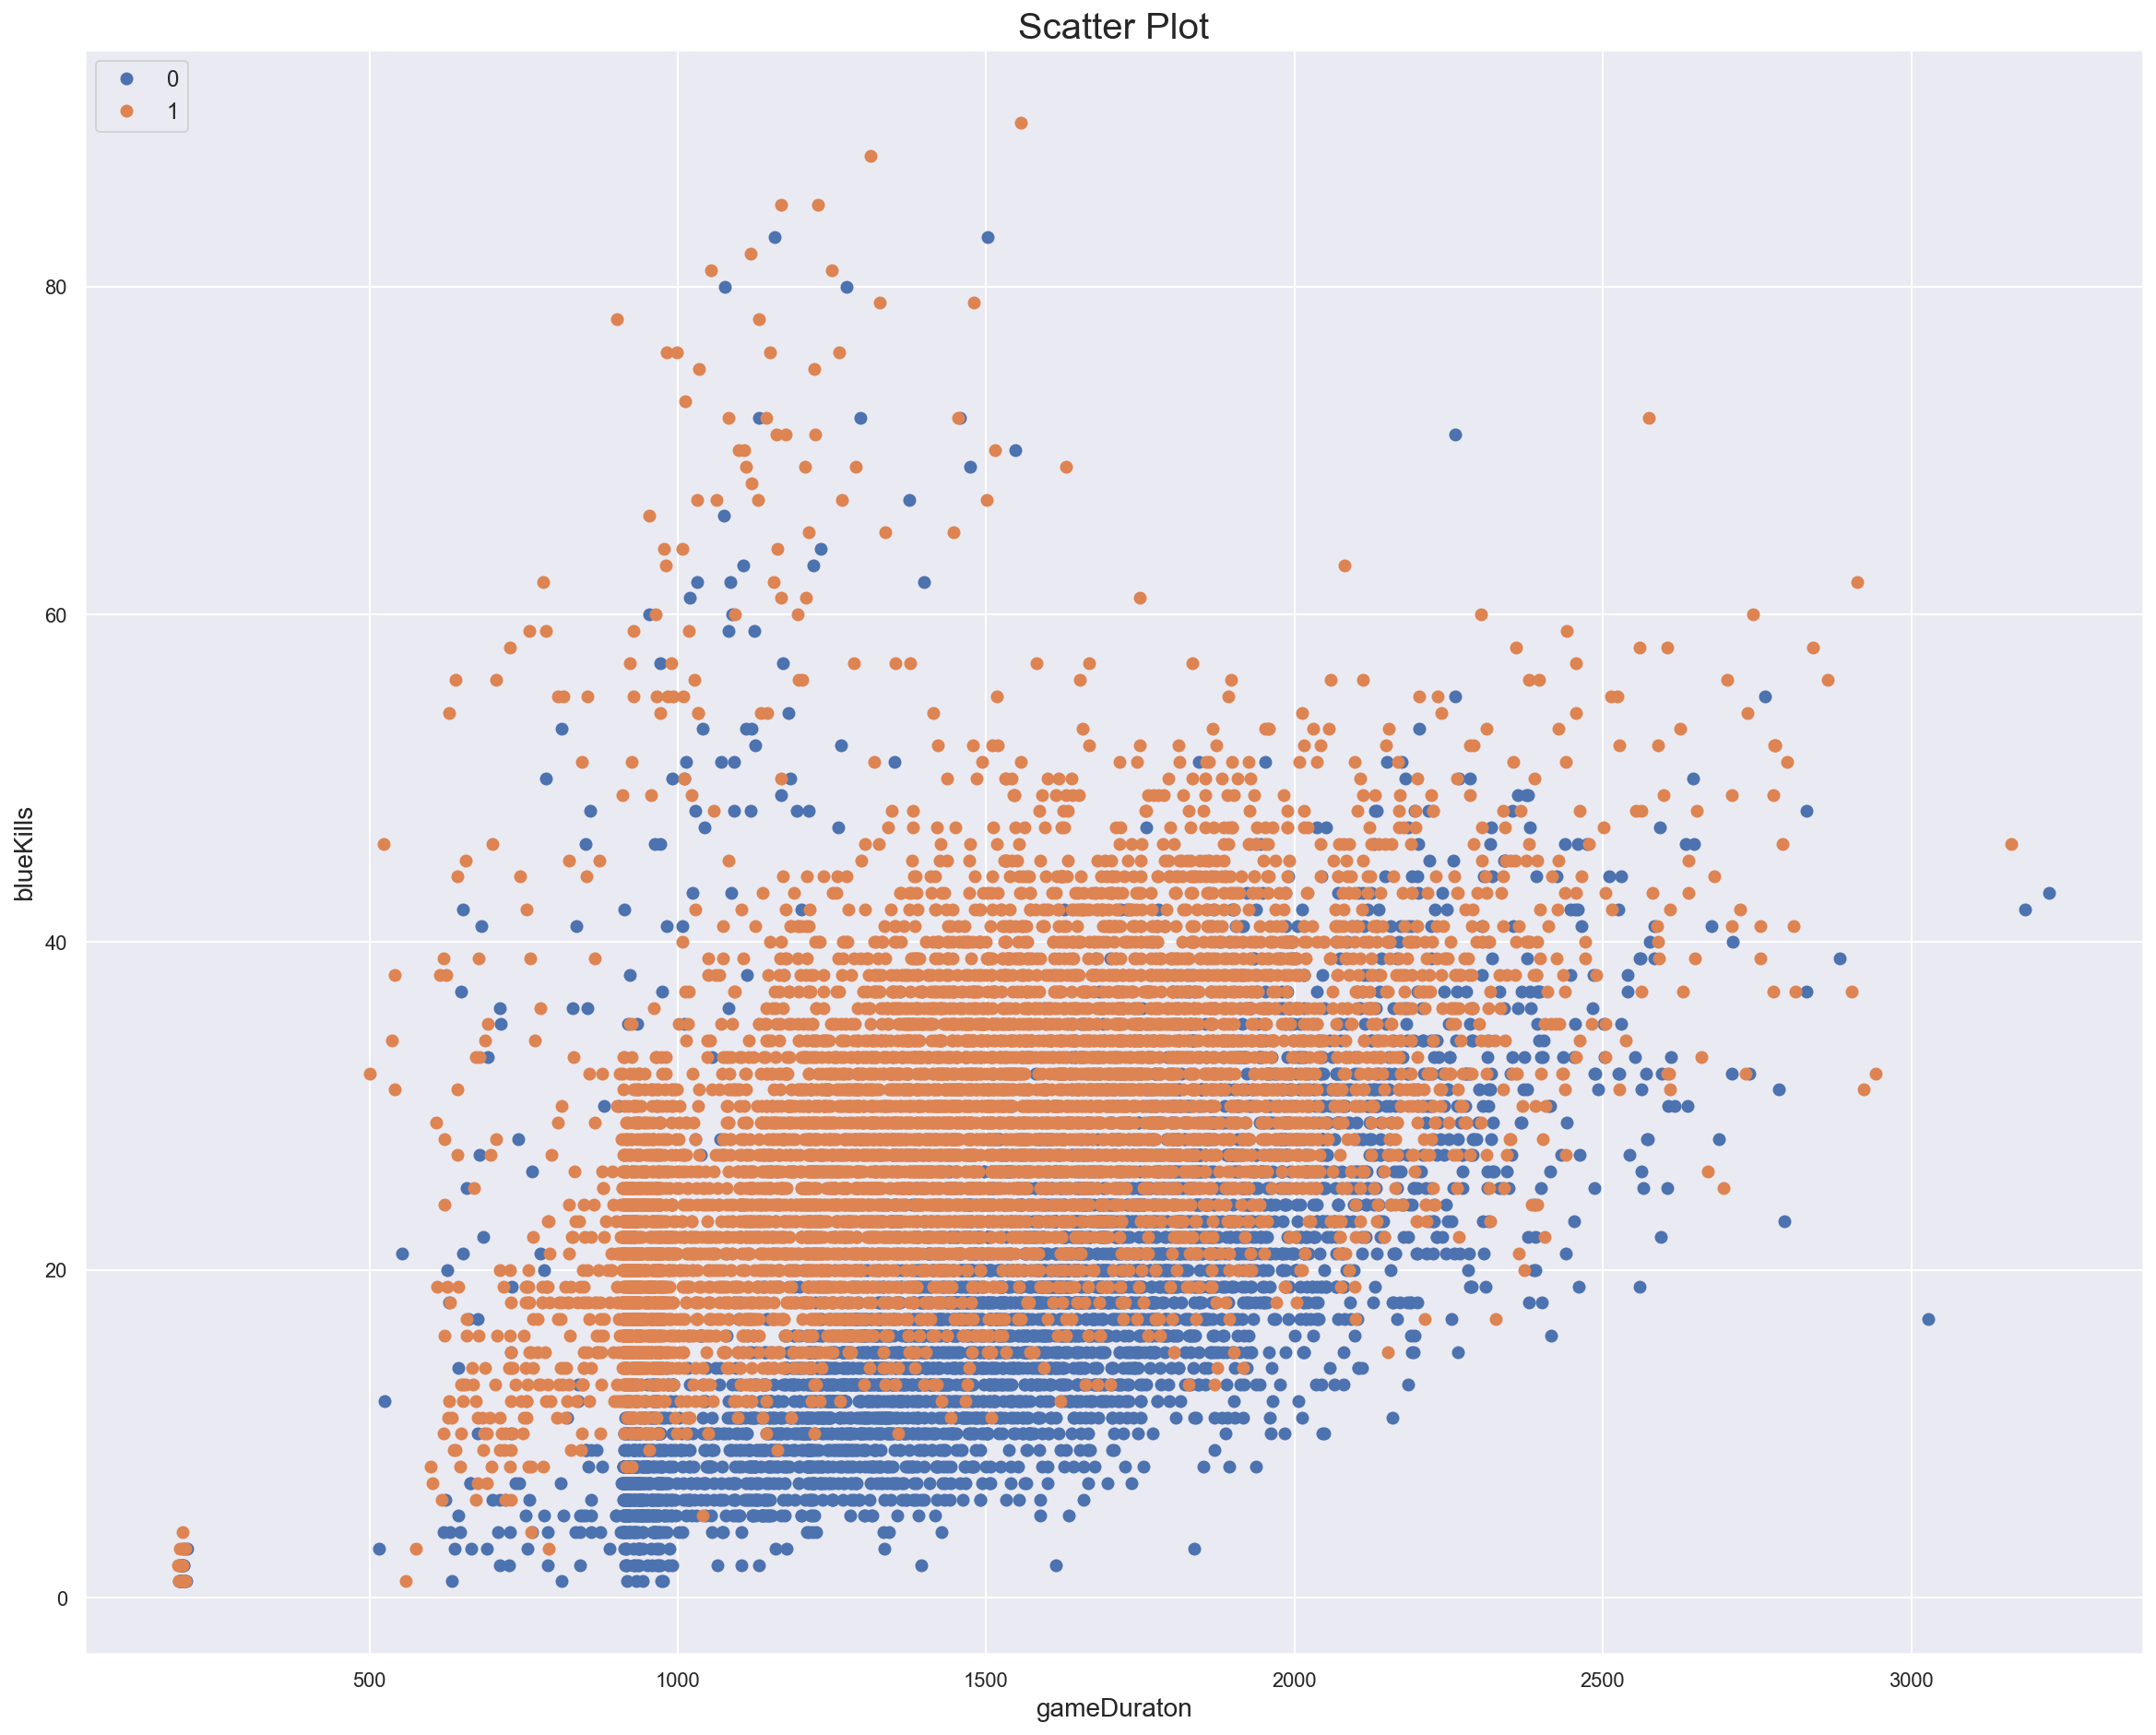

In [54]:
groups = df_full.groupby('blueWins')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.gameDuraton,
            group.blueKills,
            marker='o',
            linestyle='',
            label=name)

ax.legend(fontsize=12, loc='upper left')  # legend position

plt.title('Scatter Plot', fontsize=20)
plt.xlabel('gameDuraton', fontsize=14)
plt.ylabel('blueKills', fontsize=14)

plt.show()

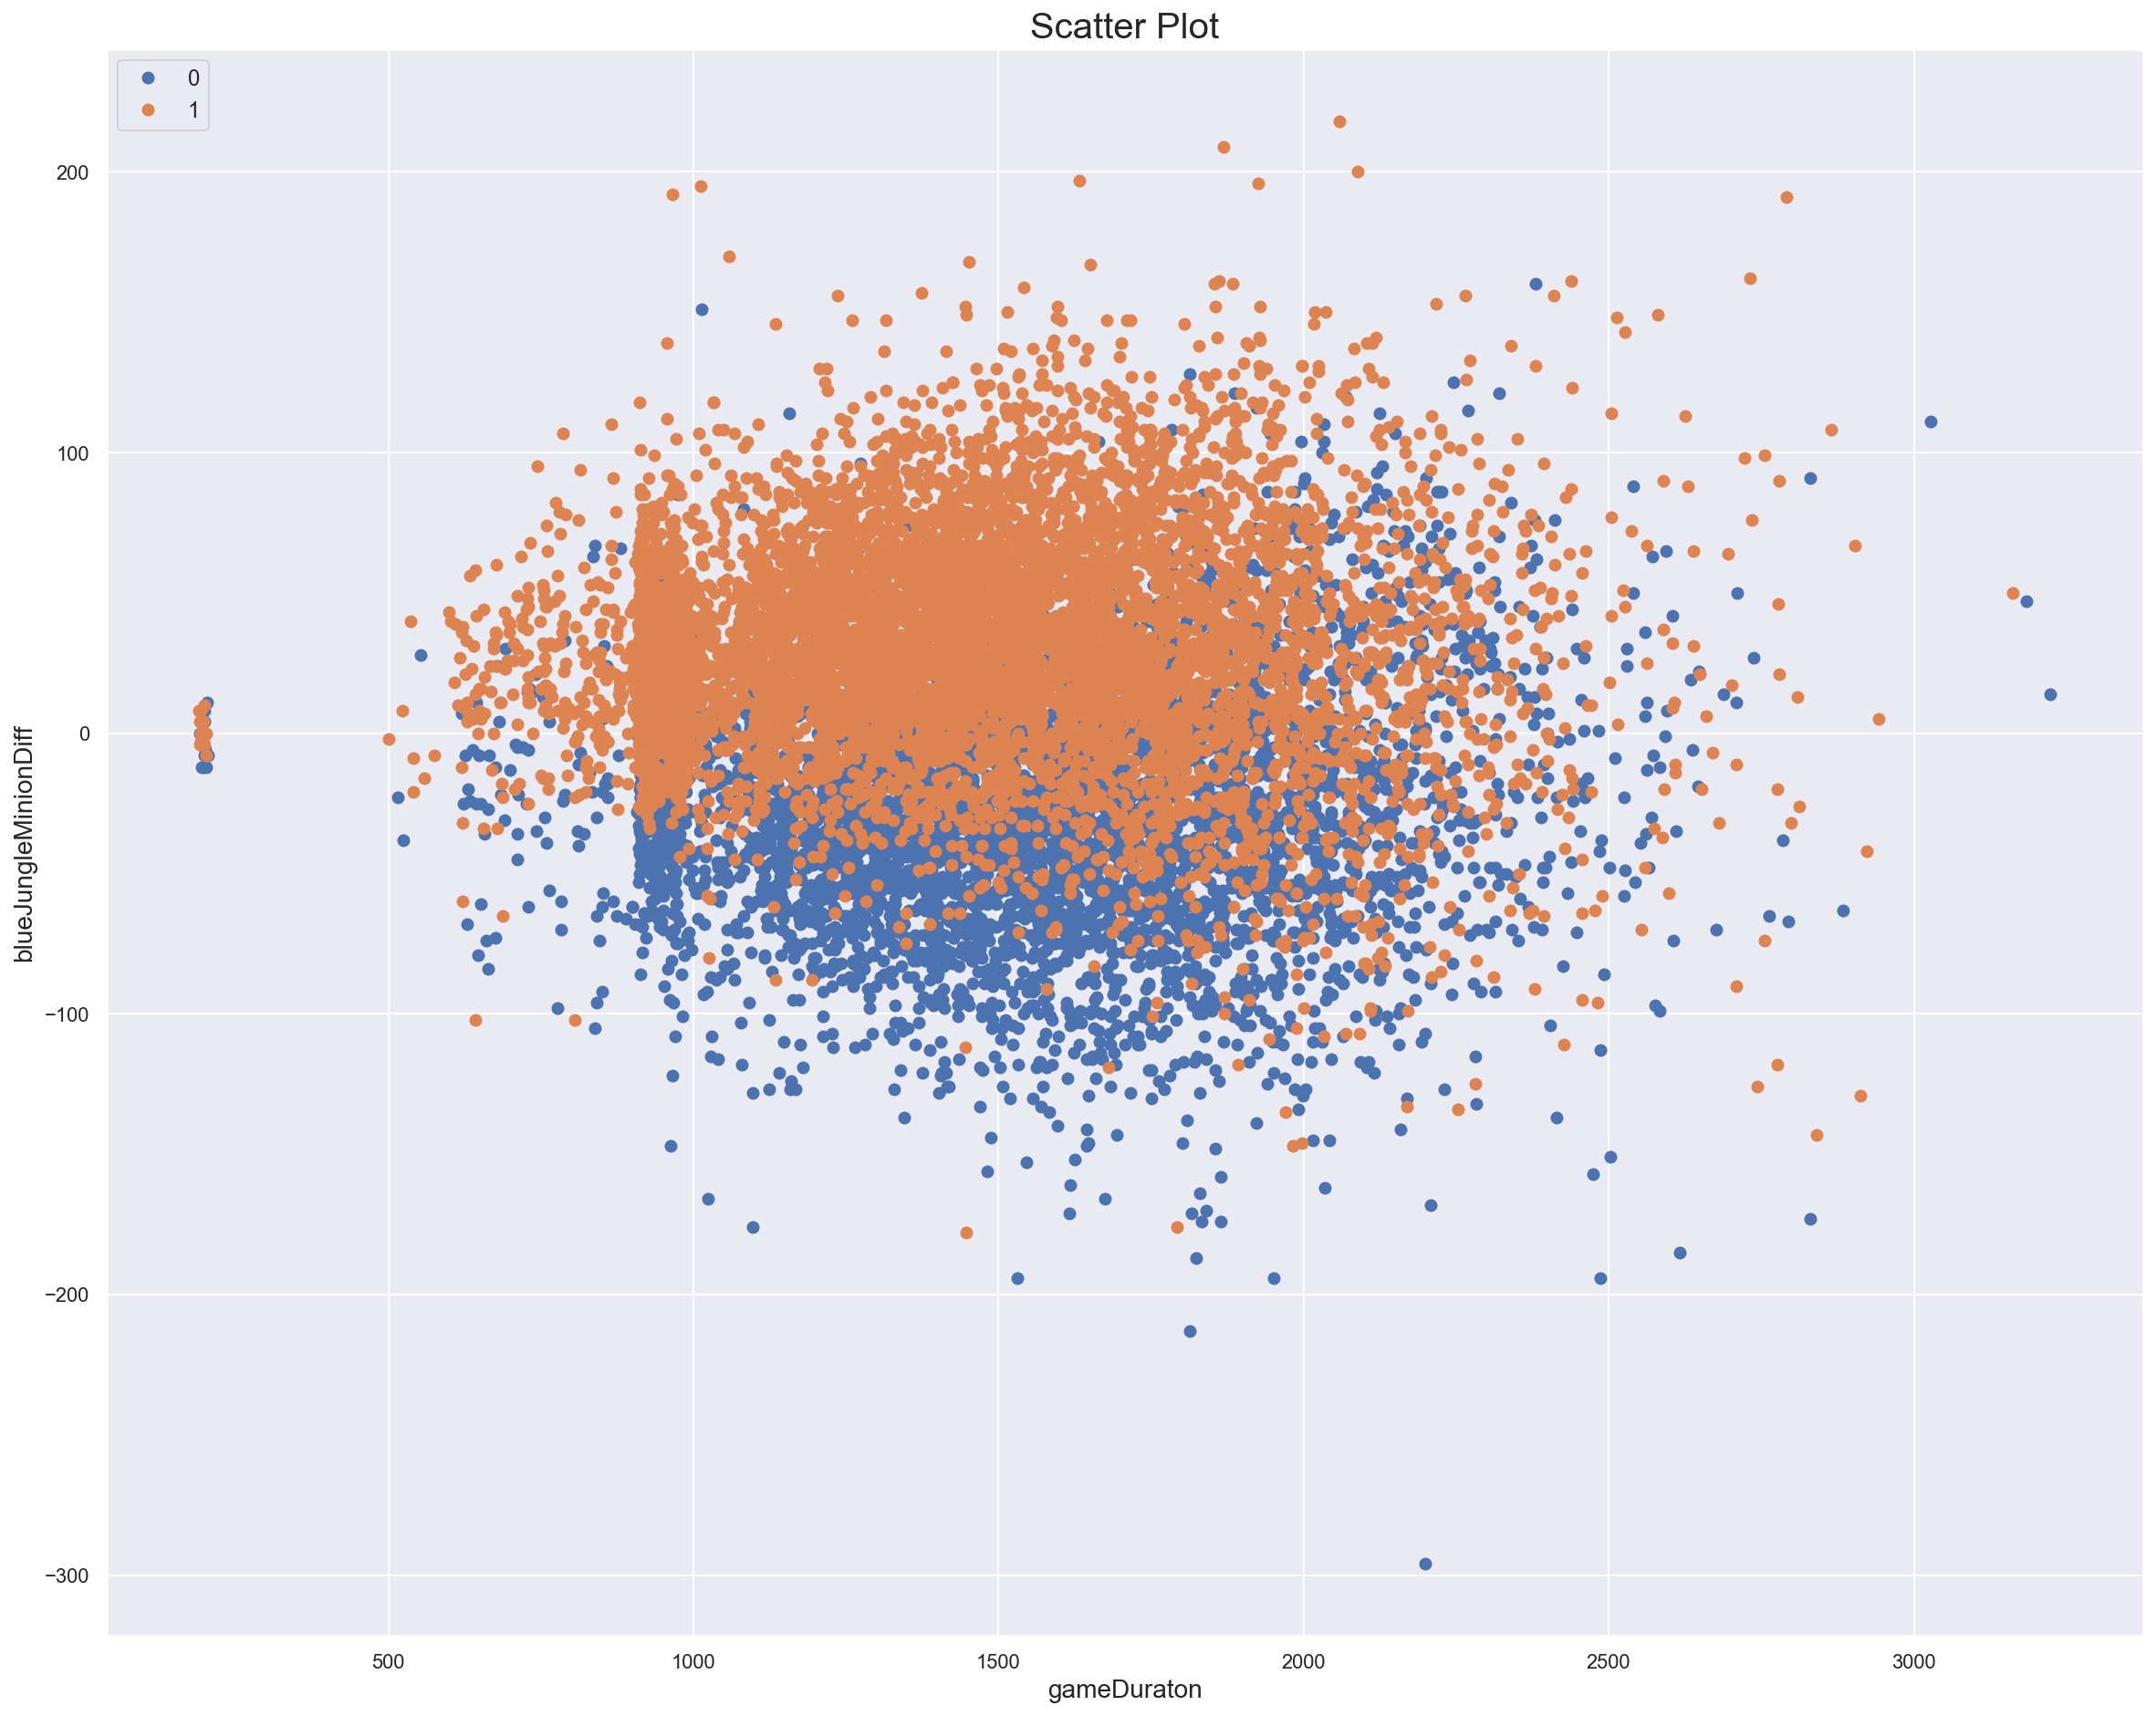

In [55]:
groups = df_full.groupby('blueWins')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.gameDuraton,

            group.blueJungleMinionDiff,
            marker='o',
            linestyle='',
            label=name)

ax.legend(fontsize=12, loc='upper left')  # legend position
plt.title('Scatter Plot', fontsize=20)
plt.xlabel('gameDuraton', fontsize=14)
plt.ylabel('blueJungleMinionDiff', fontsize=14)

plt.show()

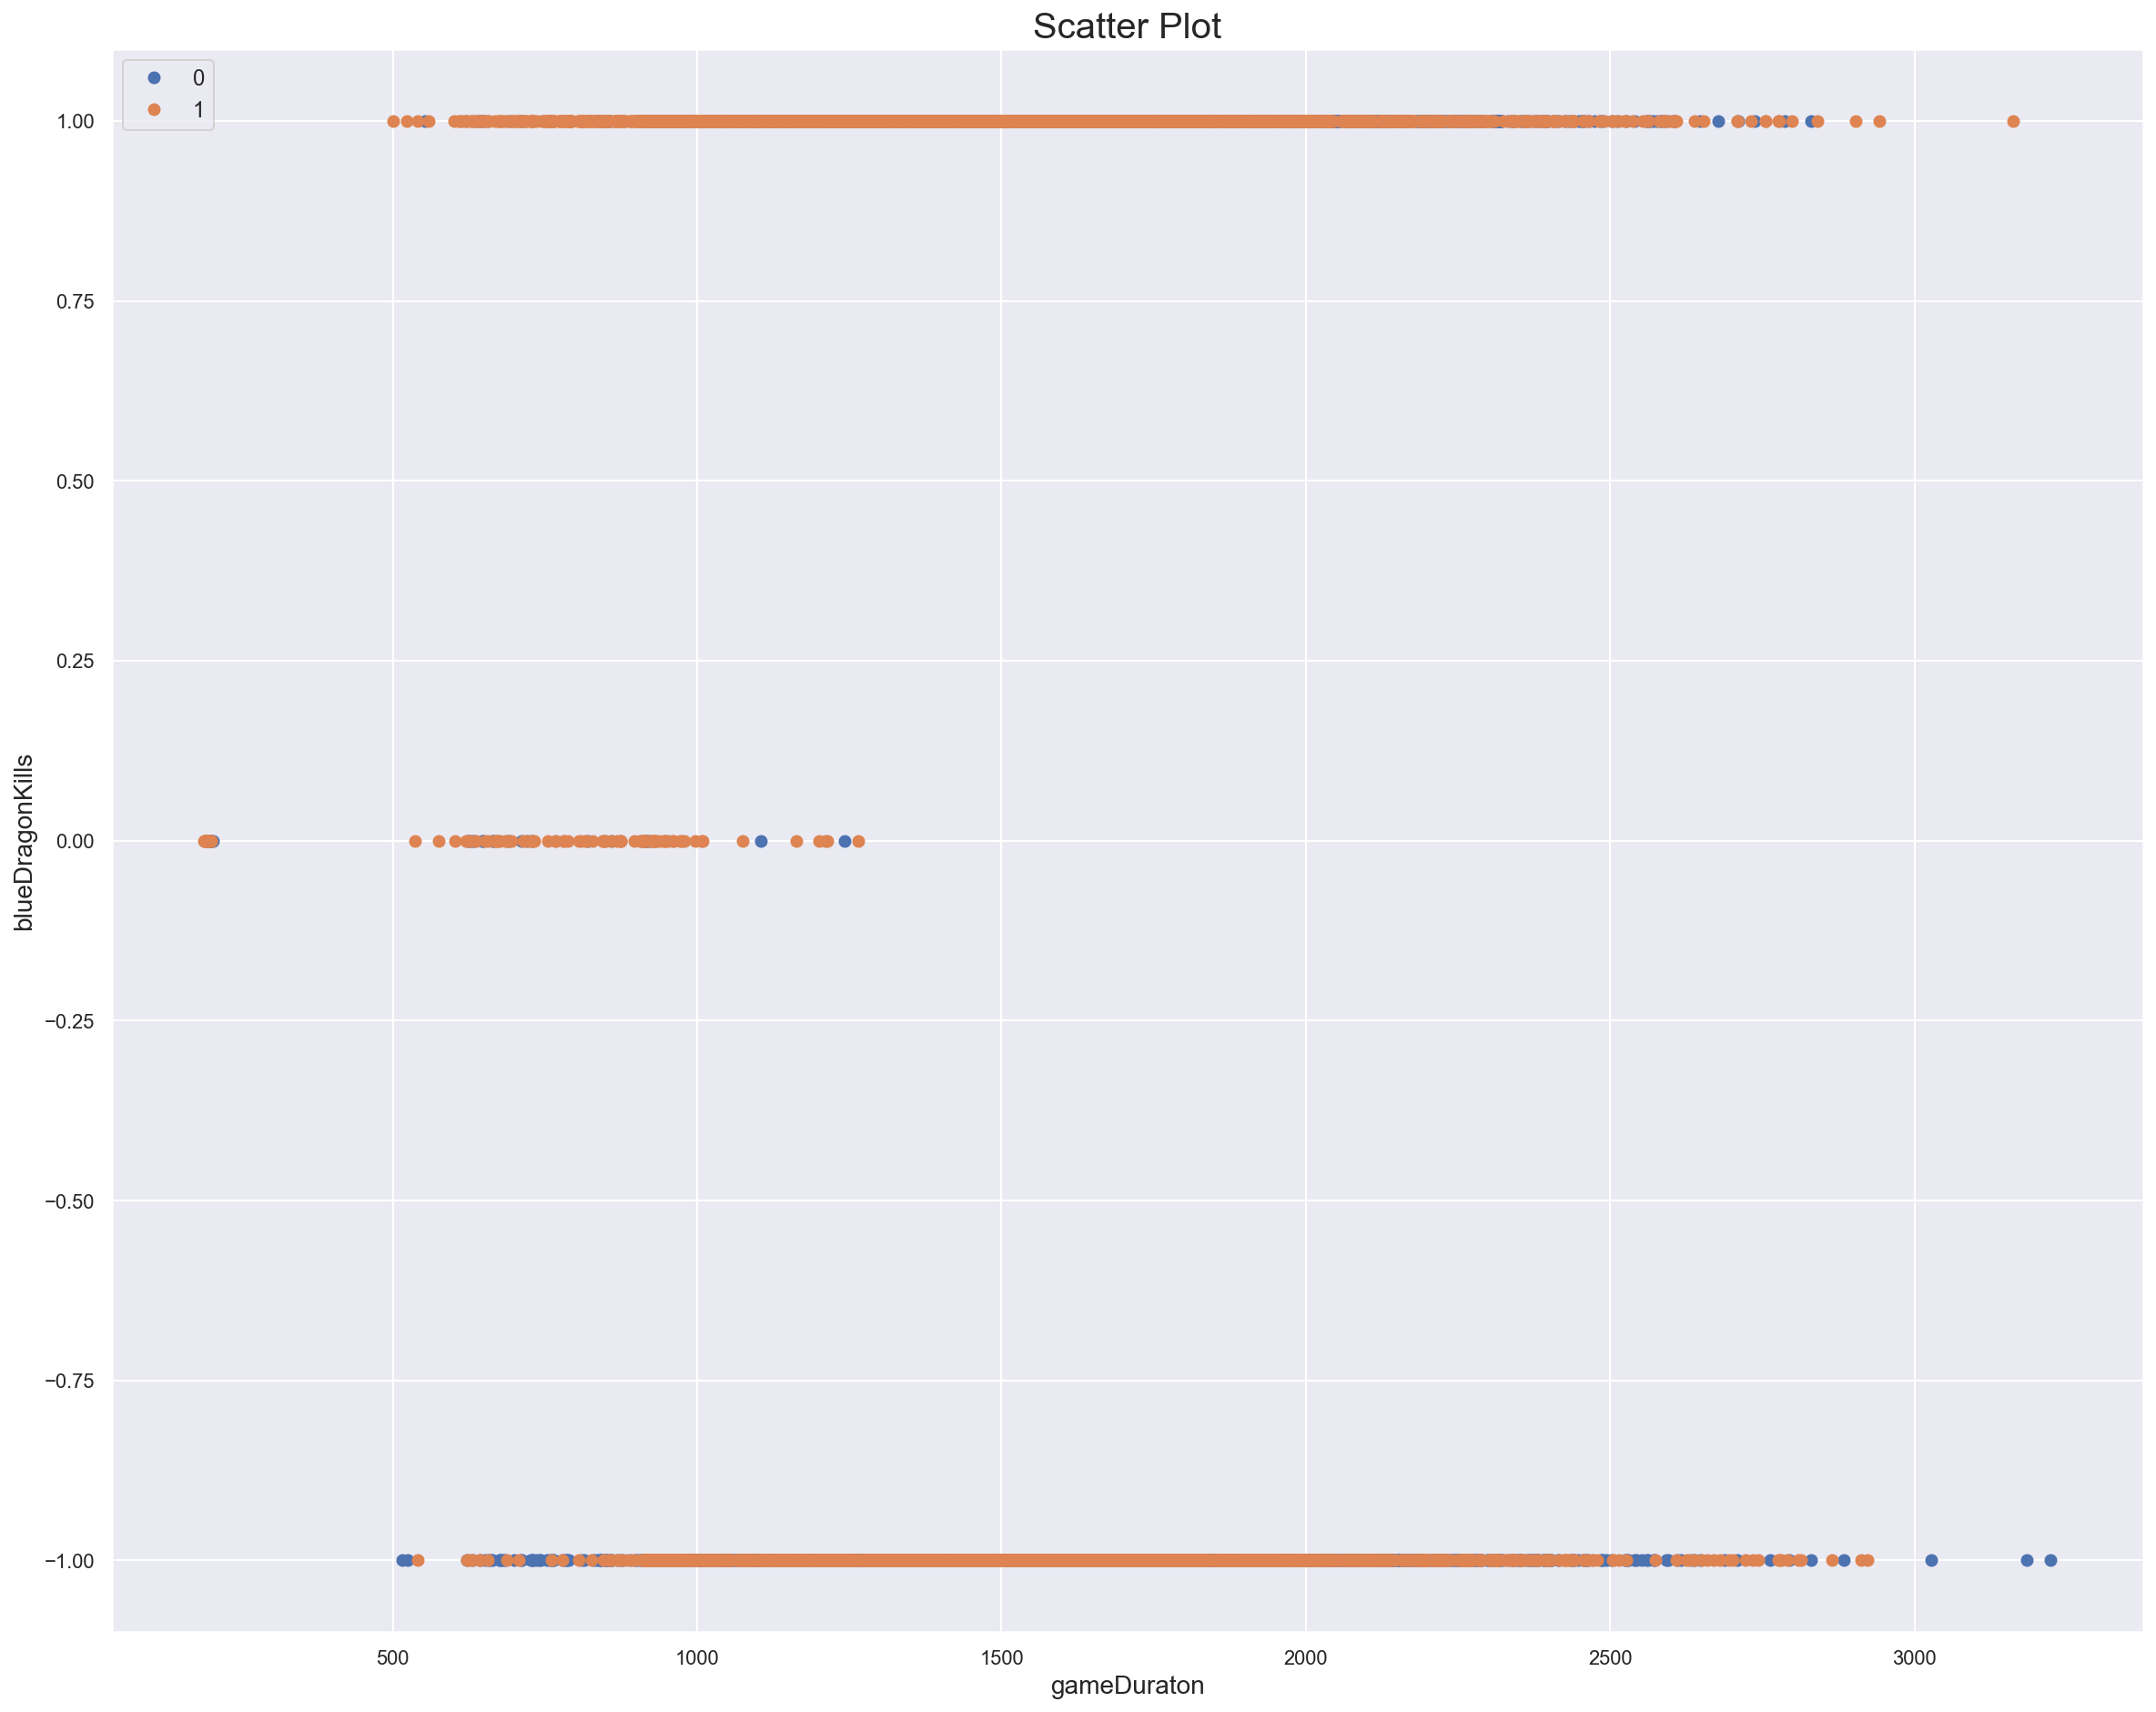

In [56]:
groups = df_full.groupby('blueWins')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.gameDuraton,
            group.FirstDragonDiff,
            marker='o',
            linestyle='',
            label=name)

ax.legend(fontsize=12, loc='upper left')

plt.title('Scatter Plot', fontsize=20)
plt.xlabel('gameDuraton', fontsize=14)
plt.ylabel('blueDragonKills', fontsize=14)

plt.show()

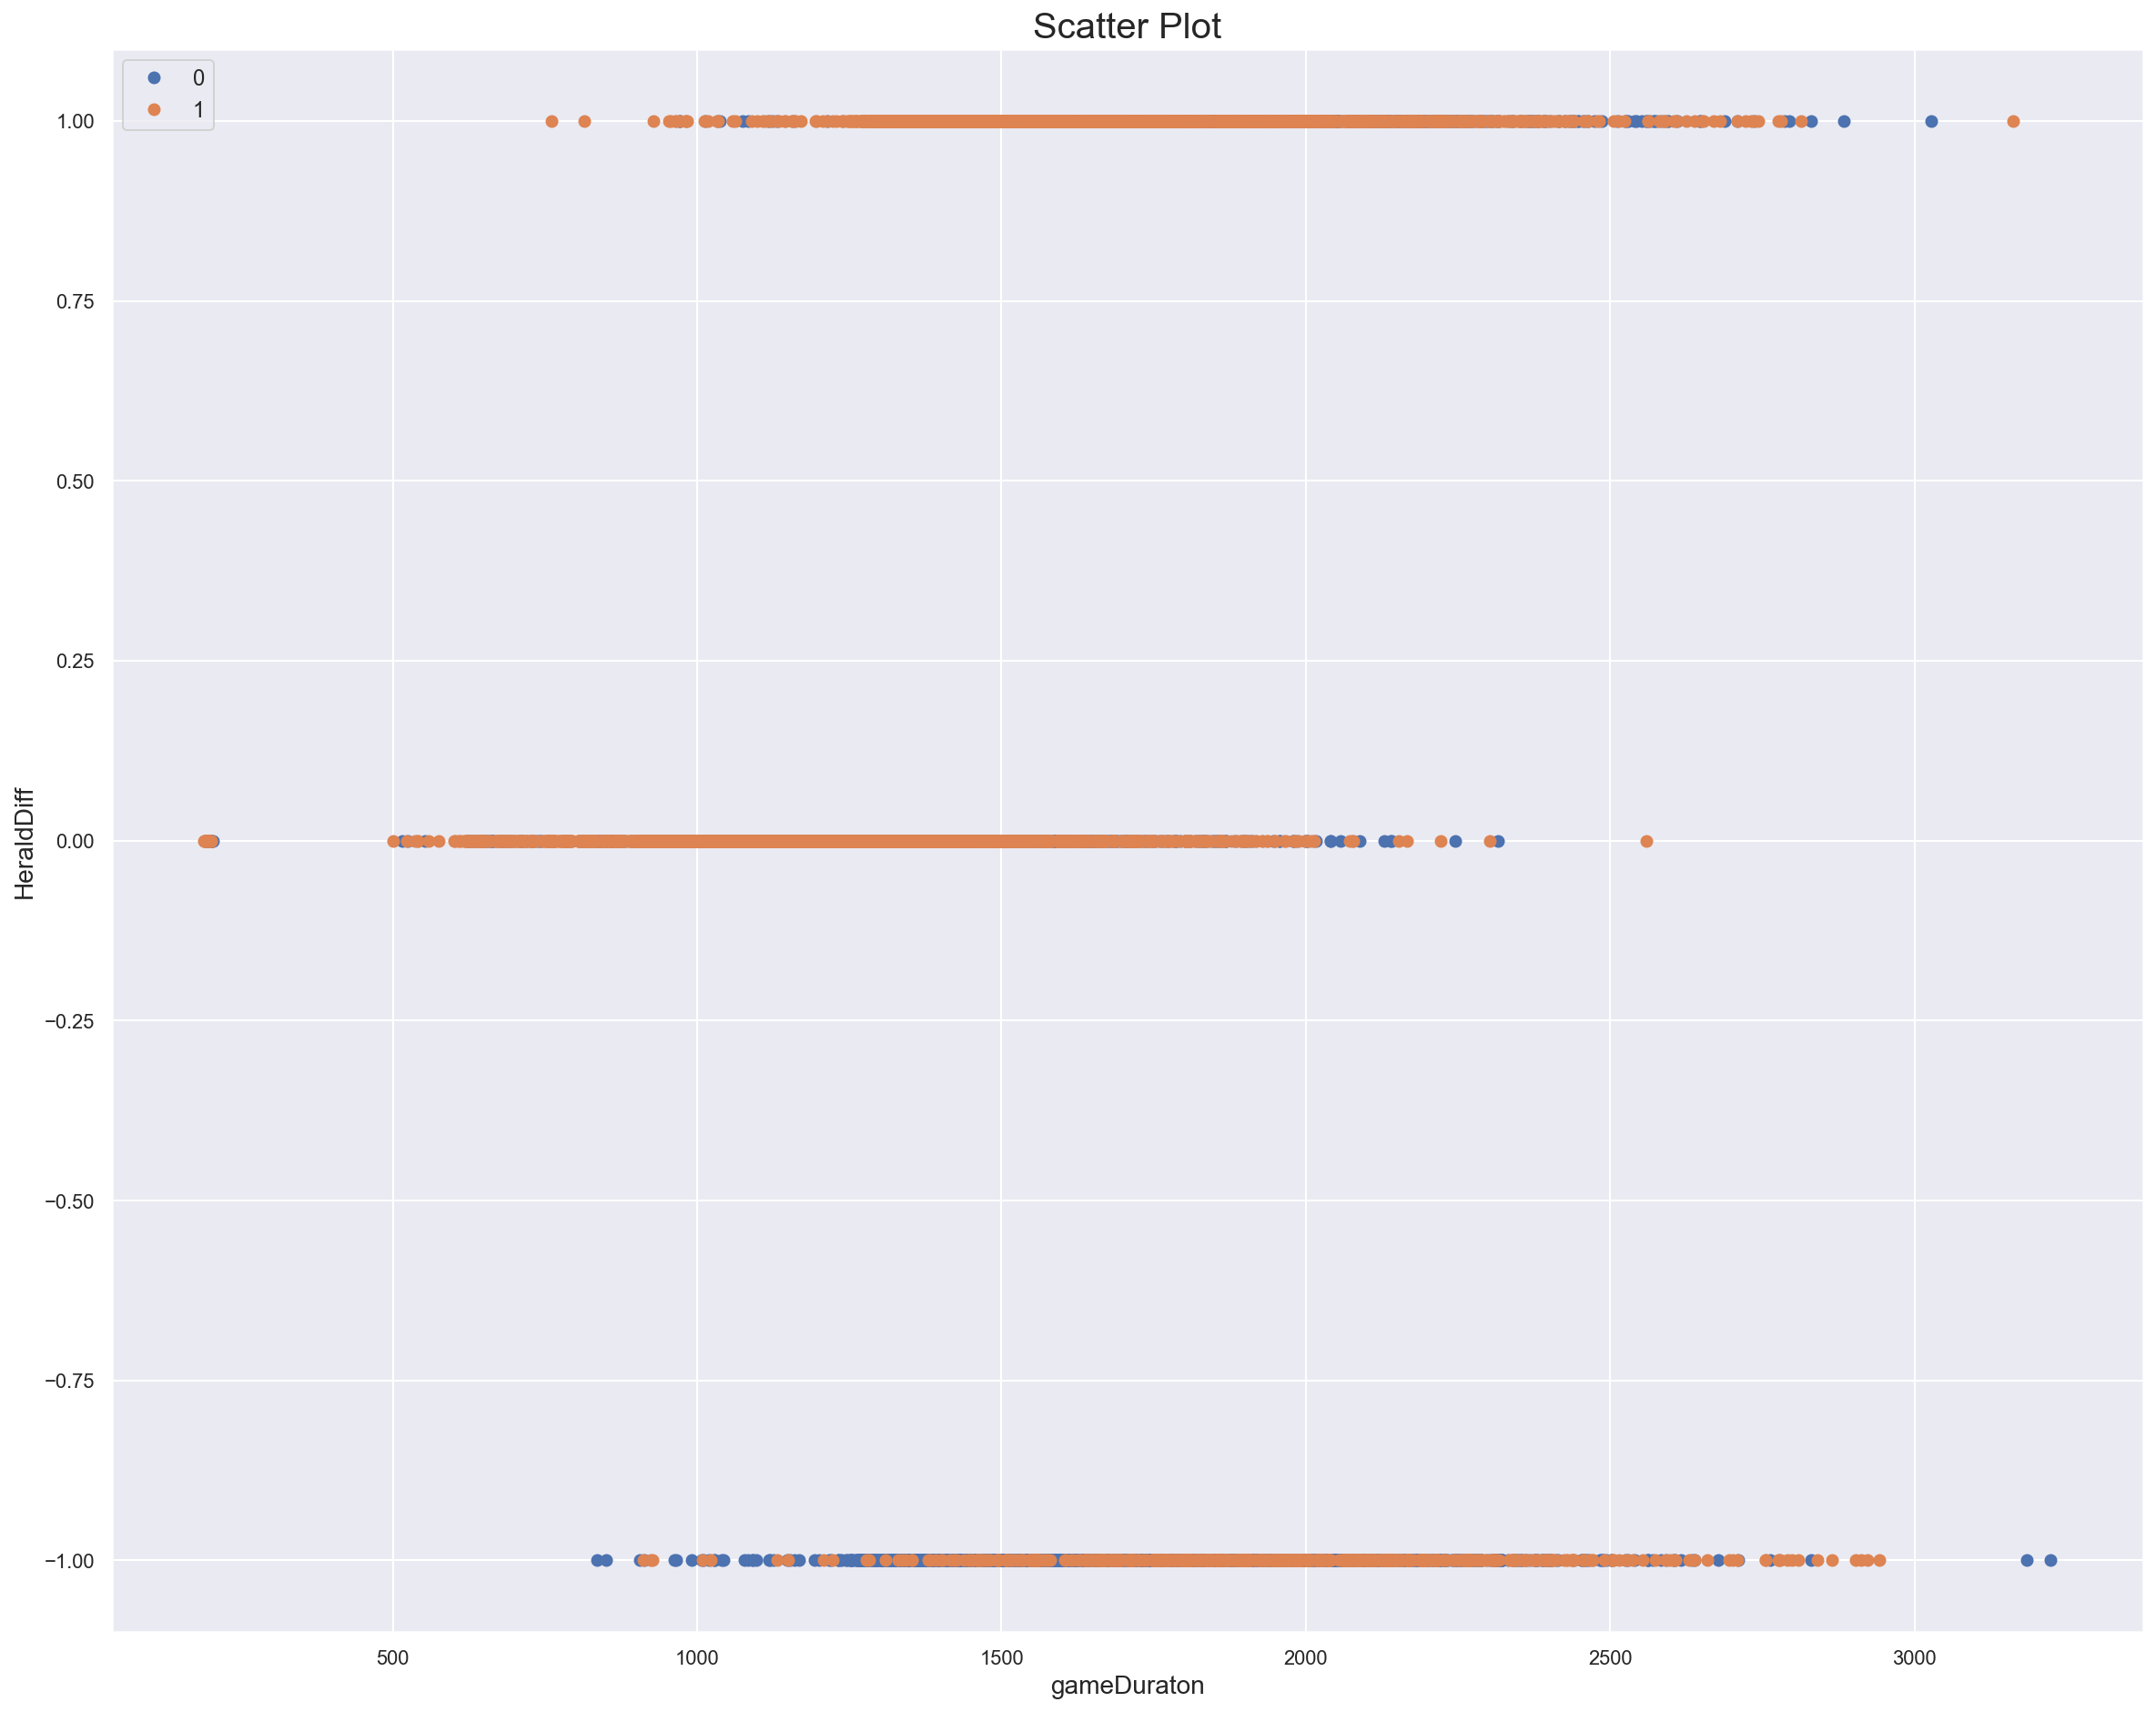

In [57]:
groups = df_full.groupby('blueWins')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.gameDuraton,
            group.HeraldDiff,
            marker='o',
            linestyle='',
            label=name)

ax.legend(fontsize=12, loc='upper left')
plt.title('Scatter Plot', fontsize=20)
plt.xlabel('gameDuraton', fontsize=14)
plt.ylabel('HeraldDiff', fontsize=14)

plt.show()

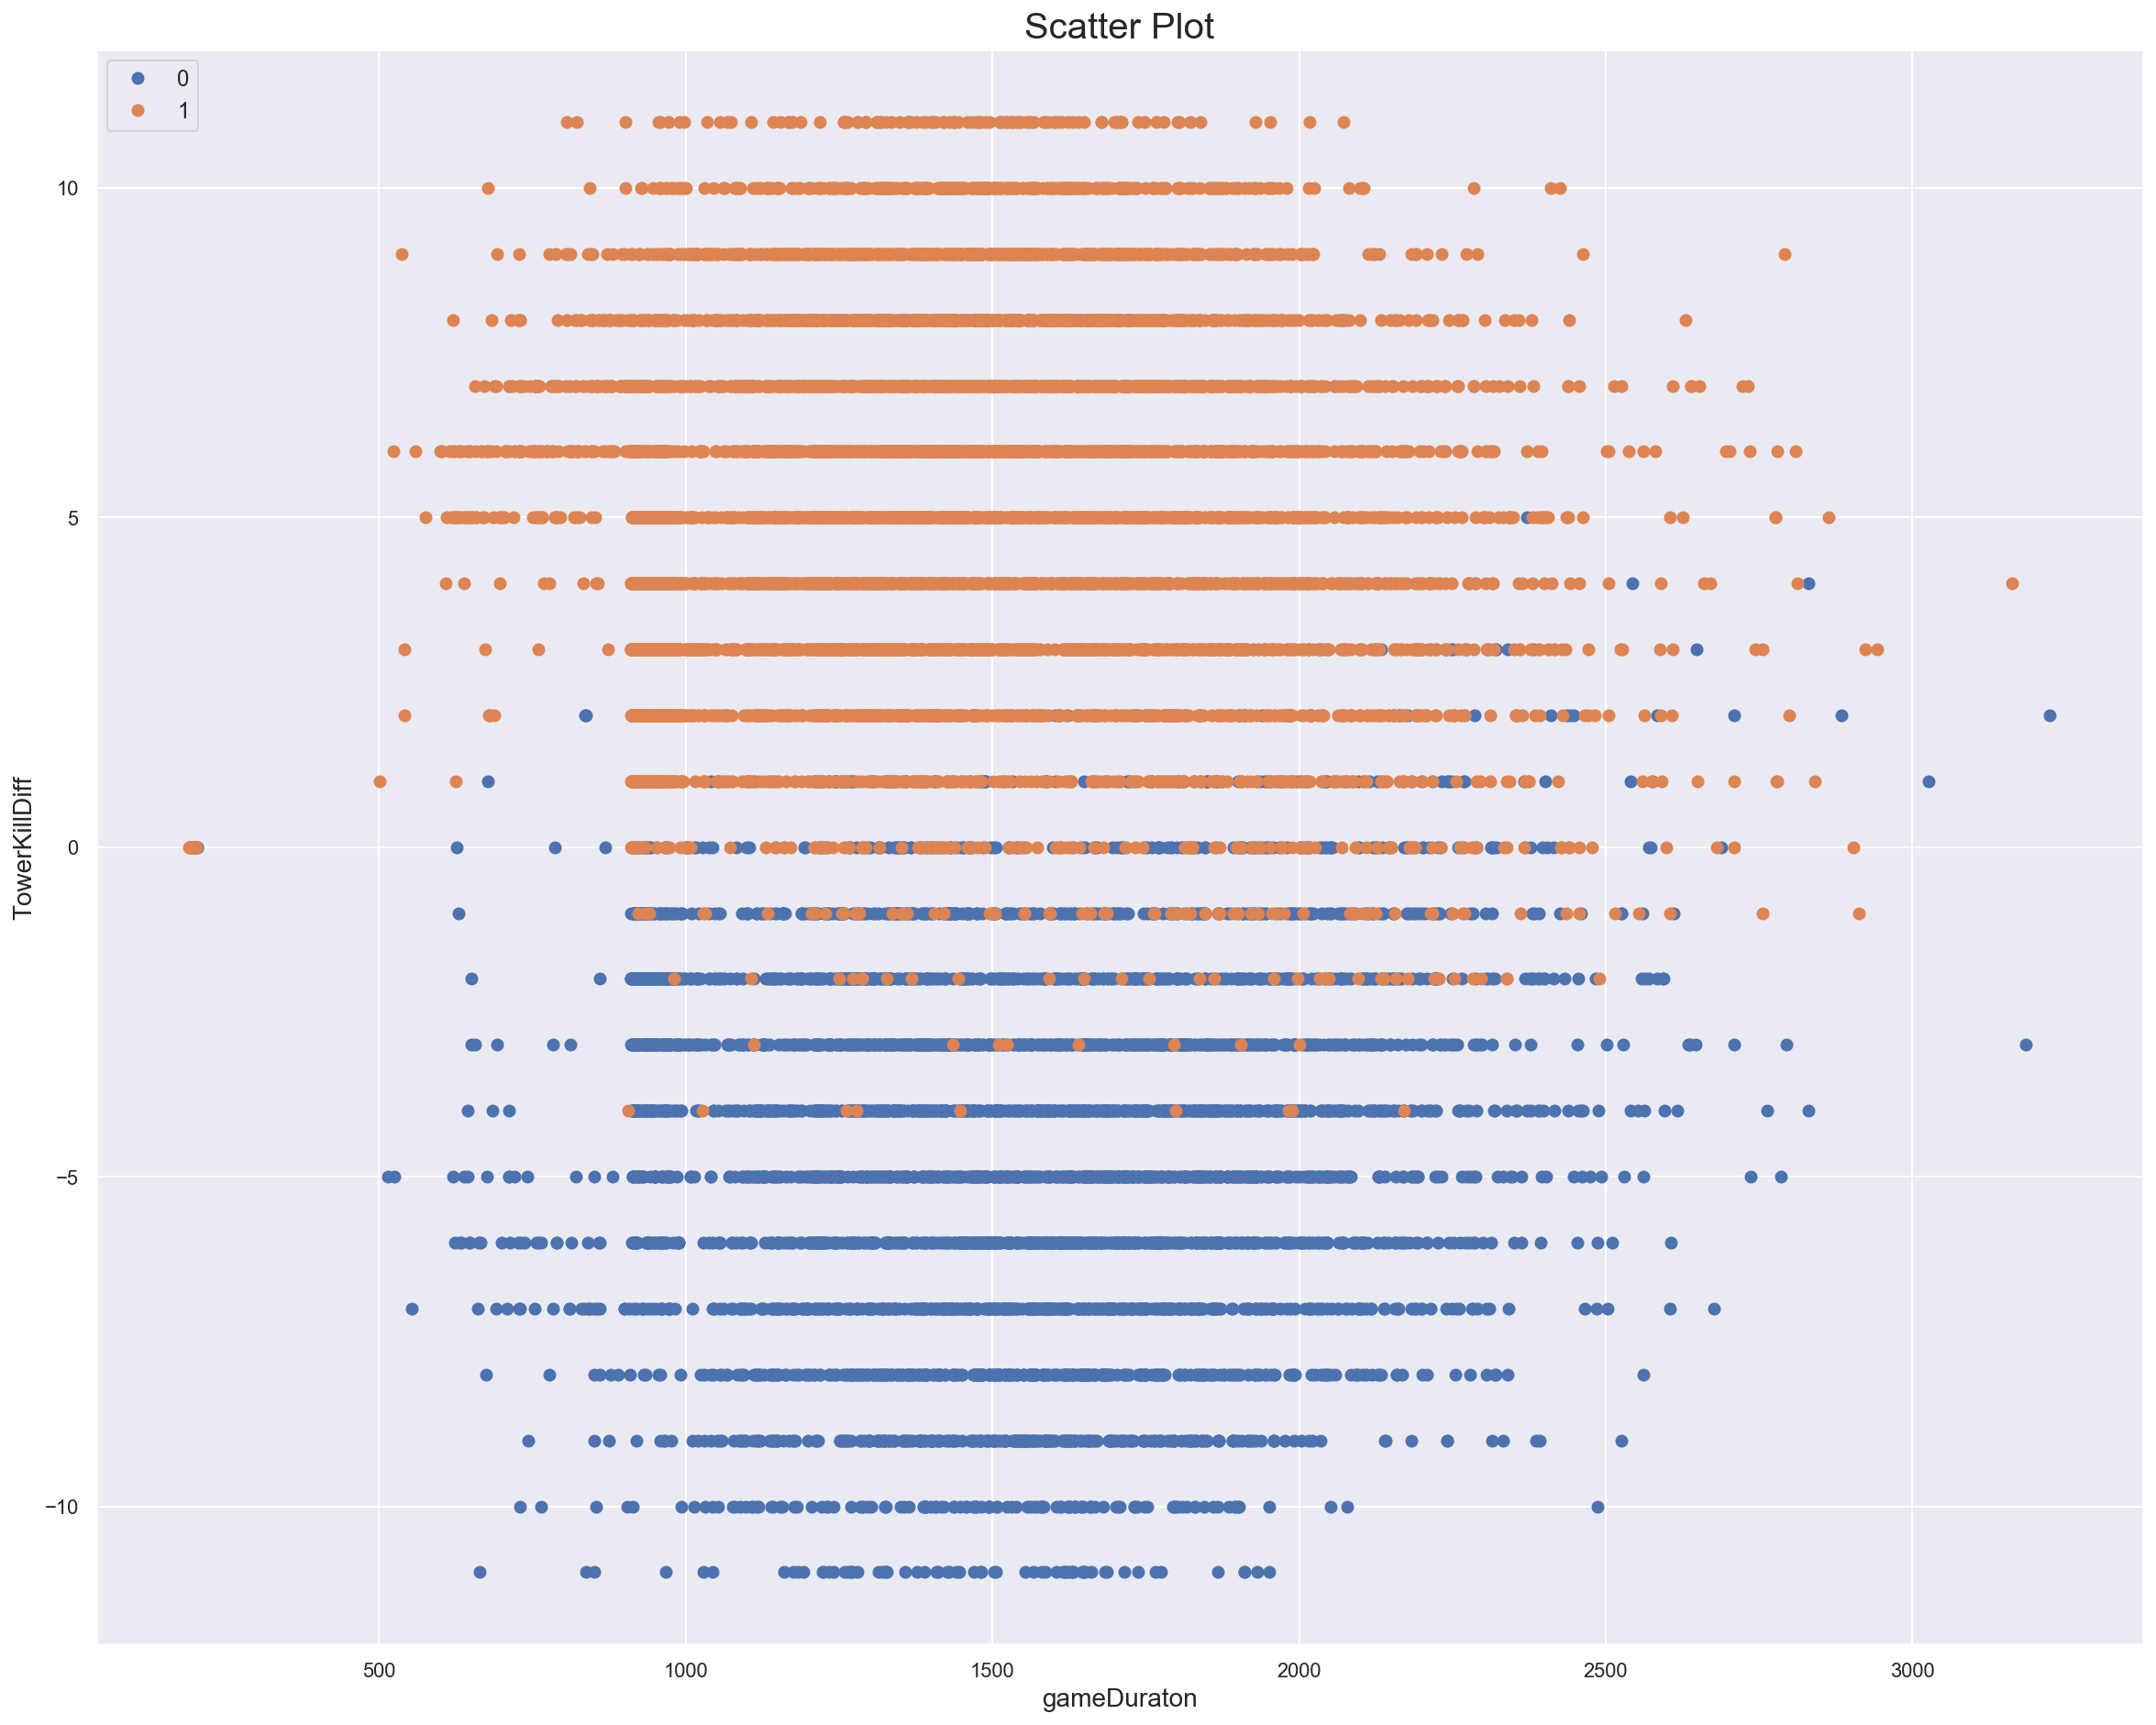

In [58]:
groups = df_full.groupby('blueWins')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.gameDuraton,
            group.TowerKillDiff,
            marker='o',
            linestyle='',
            label=name)

ax.legend(fontsize=12, loc='upper left')
plt.title('Scatter Plot', fontsize=20)
plt.xlabel('gameDuraton', fontsize=14)
plt.ylabel('TowerKillDiff', fontsize=14)

plt.show()

In [59]:
df_full['Win'], df_full['Kill'], df_full['Death'], df_full['TotalGoldDiff'], df_full['TotalMinionDiff'], df_full['TotalJungleMinionDiff']= df_full['blueWins'], df_full['blueKills'], df_full['blueDeath'],df_full['blueTotalGoldDiff'], df_full['blueTotalMinionKillDiff'], df_full['blueJungleMinionDiff']

In [60]:
df_full['FirstTower'], df_full['FirstDragon'], df_full['TotalWardsKillDiff'] = df_full['FirstTowerDiff'], df_full['FirstDragonDiff'], df_full['blueWardKillDiff']

In [61]:
df_full = df_full.drop(columns=[
 'blueWins',
 'blueKills',
 'blueDeath',
 'blueTotalGoldDiff',
 'blueTotalMinionKillDiff',
 'blueJungleMinionDiff',
 'FirstTowerDiff',
 'FirstDragonDiff',
 'blueWardKillDiff'
])

In [62]:
df_full = df_full[['gameId', 'Win', 'TotalGoldDiff', 'AvgLevelDiff', 'TotalAssistDiff', 'Kill', 'Death',  'TotalMinionDiff', 'TotalJungleMinionDiff', 'FirstTower', 'TowerKillDiff', 'HeraldDiff', 'FirstDragon','TotalWardsKillDiff']]

In [63]:
df_full.columns, len(df_full.columns)

(Index(['gameId', 'Win', 'TotalGoldDiff', 'AvgLevelDiff', 'TotalAssistDiff',
        'Kill', 'Death', 'TotalMinionDiff', 'TotalJungleMinionDiff',
        'FirstTower', 'TowerKillDiff', 'HeraldDiff', 'FirstDragon',
        'TotalWardsKillDiff'],
       dtype='object'),
 14)

In [64]:
df_full.to_csv("df_full.csv")